# Продуктовый анализ для сайта продажи билетов на мероприятия

В этом проекте мы поможем маркетологам оптимизировать рекламный бюджет. Посмотрим, какие каналы привлечения трафика эффективны, какие нет, и составим рекомендации, как распределить деньги.

**План:**

1. [Изучить данные.](#info)
2. [Предобработать:](#preprocessing)
   - заменить типы,
   - удалить дубликаты,
   - обработать пропуски.
3. [Рассчитать метрики и построить графики:](#metrics)
   - [DAU, WAU, MAU;](#au)
   - [ASL;](#asl)
   - [Retention rate;](#rr)
   - [Среднее время от первого визита до покупки;](#atfp)
   - [Среднее количество заказов на каждого пользователя;](#aoc)
   - [ARPU;](#arpu)
   - [LTV;](#ltv)
   - [CAC, ROMI.](#romi)
5. [Написать вывод.](#conclusion)

<a id="info"></a>

## Изучаем данные

In [1]:
# импортируем библиотеки, необходимые для работы
import pandas as pd # для работы с данными
import numpy as np # для работы с числами
import seaborn as sns # для визуализации
import matplotlib.pyplot as plt # для настройки визуализации
%matplotlib inline
%config InlineBackend.figure_format='retina' # повышение четкости графиков
plt.style.use('seaborn-darkgrid') # задаём стиль графиков

Прочитаем таблицы с данными и сохраним в переменные.

In [2]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

Напишем функцию, которая будет выводить сводную информацию о датасетах.

In [3]:
def info():
    '''Для каждой таблицы возвращает результаты методов info() и describe(), первые 5 строк и информацию о дубликатах'''
    for df in [visits, orders, costs]:
        display(df.info())
        display(df.describe())
        display(df.head())
        print('Дубликаты:', df.duplicated().sum())

In [4]:
info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Дубликаты: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Дубликаты: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Дубликаты: 0


Видим несколько проблем:
1. В названиях столбцов используются строчные буквы и пробелы.
2. Даты имеют строковый тип.
3. В столбце с выручкой в таблице `orders` есть выбросы: 75%-й квантиль меньше 5, а максимальное значение — больше 2500.

Пропусков и дубликатов в данных нет.

<a id="preprocessing"></a>

## Предобработка

Приведём в порядок названия столбцов: сделаем все буквы прописными, а пробелы заменим на подчеркивание.

In [5]:
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

Также при помощи цикла поменяем тип данных столбцов с датой на `datetime`.

In [6]:
for df in [visits, orders, costs]:
    for column in df.columns:
        if df[column].dtypes == 'object':
            try:
                df[column] = pd.to_datetime(df[column])
            except:
                df[column] = df[column]

Проверим, что всё прошло успешно.

In [7]:
info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


None

,source_id,uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Дубликаты: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Дубликаты: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


None

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Дубликаты: 0


Типы данных в порядке, названия столбцов — тоже. Посмотрим на выбросы.

In [8]:
orders[orders['revenue']==orders['revenue'].max()]

,buy_ts,revenue,uid
23244,2017-12-10 20:17:00,2633.28,5539673724080479777


Пользователь *5539673724080479777* совершил покупку на более чем **2500 у.е.**, в то время как 75% пользователей покупают меньше чем на 5 у.е. Проверим, покупал ли он ещё и на какие суммы.

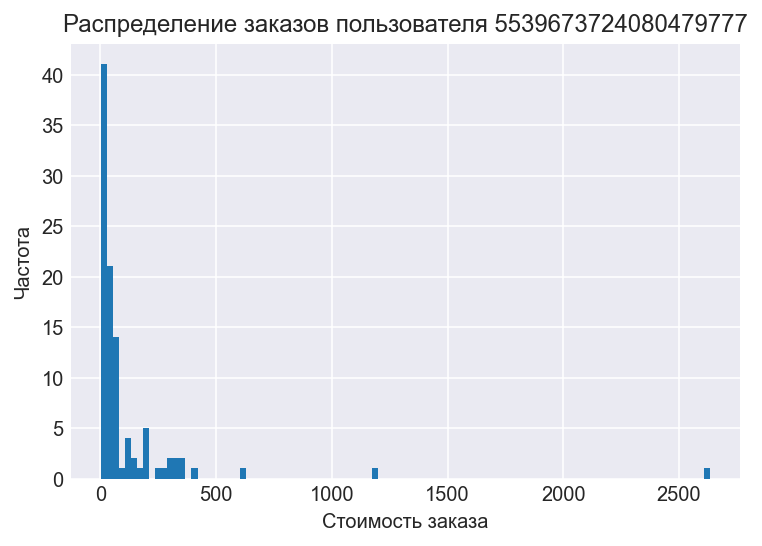

In [9]:
orders[orders['uid']==5539673724080479777]['revenue'].hist(bins=101)
plt.title('Распределение заказов пользователя 5539673724080479777')
plt.xlabel('Стоимость заказа')
plt.ylabel('Частота');

Пользователь *5539673724080479777* несколько раз совершал дорогие покупки. Возможно, он покупал VIP-места на концерт или покупал билеты на большую компанию.  
  
На диаграмме размаха посмотрим, какую выручку с продажи статистически можно считать выбросом.

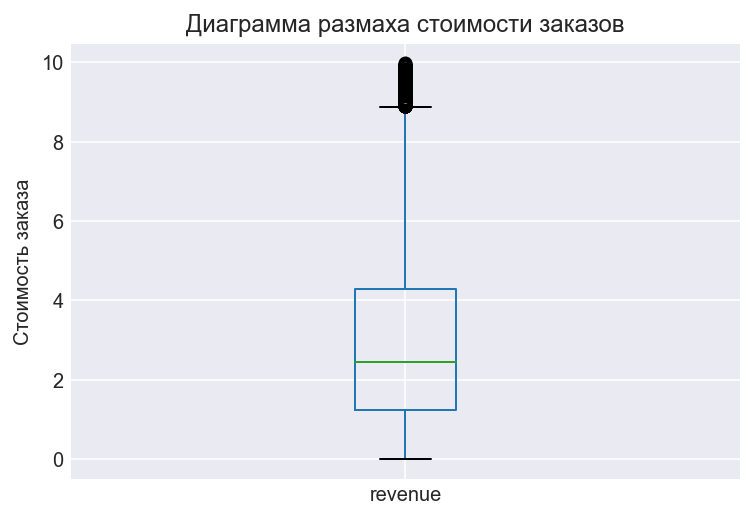

In [10]:
orders.query('revenue<10').boxplot('revenue')
plt.title('Диаграмма размаха стоимости заказов')
plt.ylabel('Стоимость заказа');

Продажи больше чем на 9 у.е. — редкость и с математической точки зрения являются выбросами. Посмотрим, какой процент заработанных денег приходится на такие заказы.

In [11]:
orders.query('revenue>9')['revenue'].sum() / orders['revenue'].sum()

0.49801652164667387

Редкие но дорогие заказы приносят **половину всей выручки.** Избавляться от них при подсчётах нельзя.

### Вывод

Данные приведены к нужным типам, названия столбцов удобны для работы. Дорогие покупки оставляем, потому что на них приходится половина выручки.

<a id="metrics"></a>

## Анализируем данные

В таблице с посещениями страницы создадим столбцы с датой (без времени), неделей, месяцем и годом захода на сайт. Эти данные пригодятся при подсчёте пользовательской активности.

In [12]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date

<a id="au"></a>

### DAU

Посчитаем ежедневную активность пользователей: сгруппируем таблицу по дням и посчитаем уникальных юзеров.

In [13]:
dau = visits.groupby(['session_date'])['uid'].nunique().reset_index()

In [14]:
dau.tail(3)

,session_date,uid
361,2018-05-29,948
362,2018-05-30,1289
363,2018-05-31,1997


Посчитаем среднее количество активных пользователей в день.

In [15]:
dau['uid'].mean()

907.9917582417582

В день на сайт в среднем заходят 908 человек.

Чтобы построить график, который покажет изменение метрики во времени, напишем функцию.

In [16]:
def au_plot(data, x, title, xlabel):
    '''Возвращает график пользовательской активности за определенный период.
    Параметры:
    data (DataFrame) — таблица, по которой строим график
    x (Series) — столбец, который будет отложен по оси X
    title (str) — заголовок графика
    xlabel (str) — подпись оси X
    hue (str) — разделение величины по третьему значению'''
    plt.figure(figsize=(10,5)) # задаем размер фигуры
    sns.lineplot( # строим график
        x=x,
        y='uid',
        data=data,
        color='indianred'
    ) # задаем цветовую схему
    plt.title(title, fontsize=16, fontweight='bold') # заголовок
    plt.xlabel(xlabel, fontsize=12) # подпись оси X
    plt.ylabel('Количество посетителей', fontsize=12); # подпись оси Y

При помощи функции построим график изменения DAU.

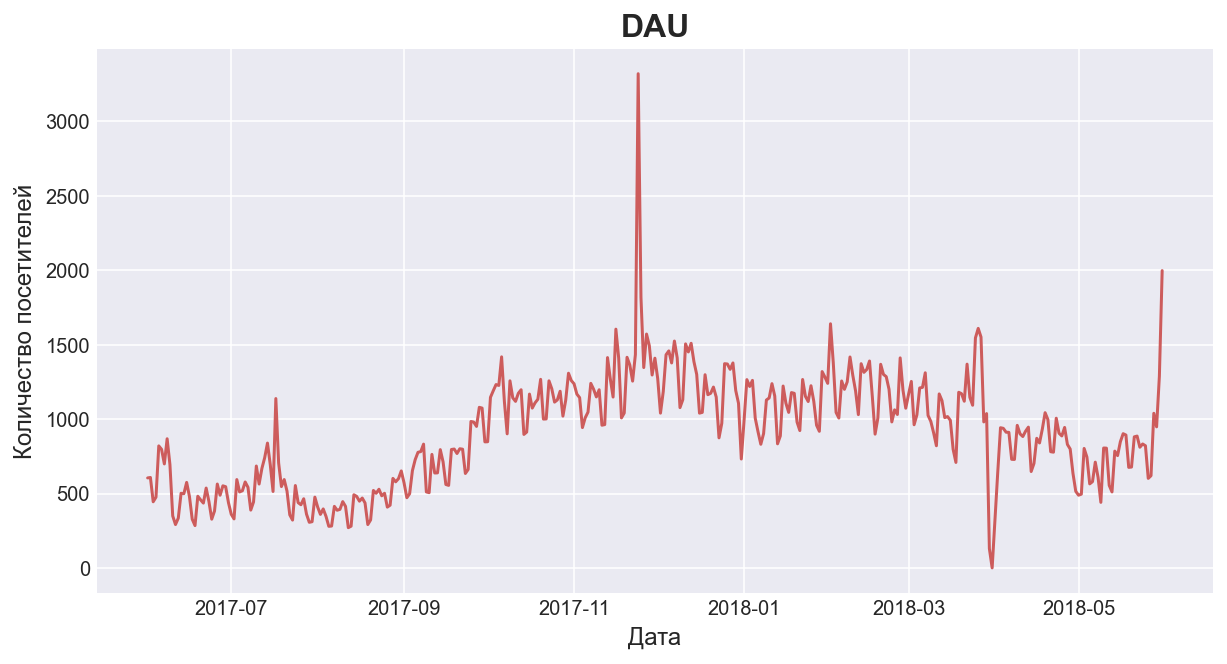

In [17]:
au_plot(dau, 'session_date', 'DAU', 'Дата')

В целом видна тенденция к увеличению количества пользователей в холодное время года и снижению — в теплое. Люди больше гуляют и ездят за город и реже ходят в театры и кино.  
  
Виден большой пик в конце ноября и сильный спад в конце марта или начале апреля. Посмотрим на эти данные отдельно.

In [18]:
dau[dau['uid']==dau['uid'].max()]

,session_date,uid
176,2017-11-24,3319


*24 ноября 2017 года* на сайт зашло в 3 раза больше людей, чем обычно. Возможно, в тот день открылась продажа билетов на какой-то концерт.

In [19]:
dau[dau['uid']==dau['uid'].min()]

,session_date,uid
303,2018-03-31,1


*31 марта 2018 года* на сайт зашёл всего **один человек.** Возможно, сайт был недоступен. Нужно связаться с техподдержкой и выяснить, в чём проблема.

### WAU

Таким же способом проанализируем данные о еженедельной активности пользователей.

In [20]:
wau = visits.groupby('session_week')['uid'].nunique().reset_index()
wau['uid'].mean()

5724.415094339623

За неделю на сайт заходят в среднем около 5700 человек. Посмотрим на график изменения WAU во времени. Используем ранее написанную функцию `au_plot`.

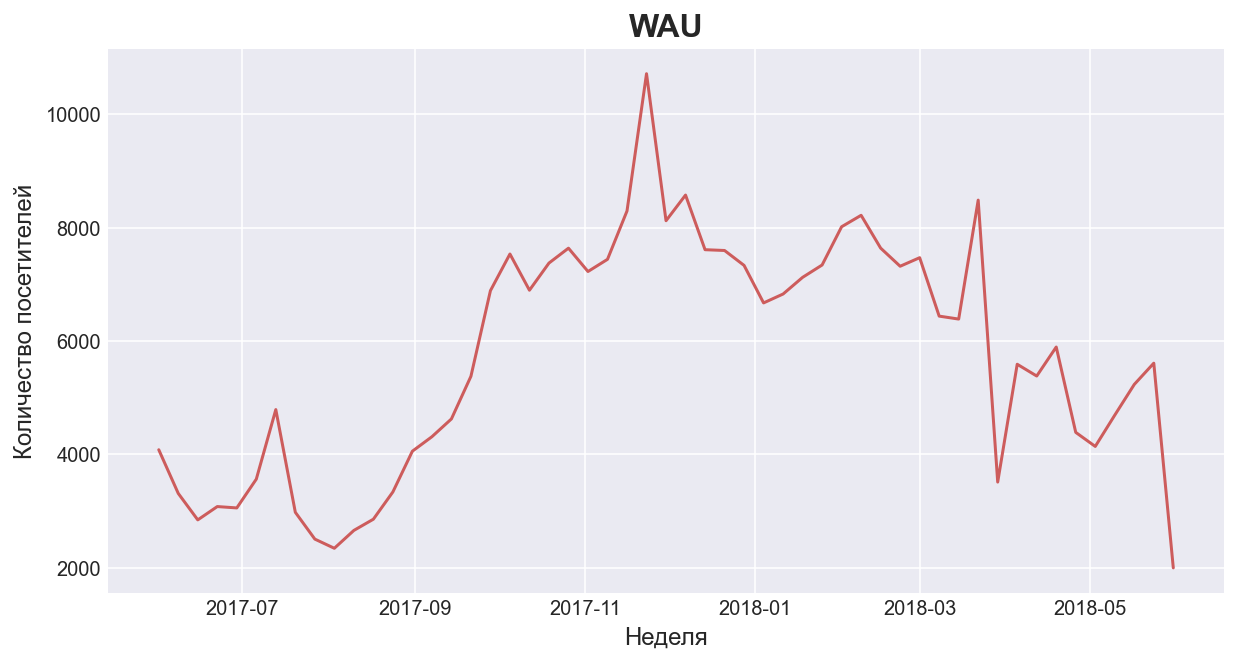

In [21]:
au_plot(wau, 'session_week', 'WAU', 'Неделя')

Даже более явно стало видно снижение числа заходов на сайт в тёплое время года.

### MAU

Теперь посмотрим на ежемесячную активность.

In [22]:
mau = visits.groupby('session_month')['uid'].nunique().reset_index()
mau['uid'].mean()

23228.416666666668

Средняя ежемесячная аудитория сайта — около 23 тысяч человек.

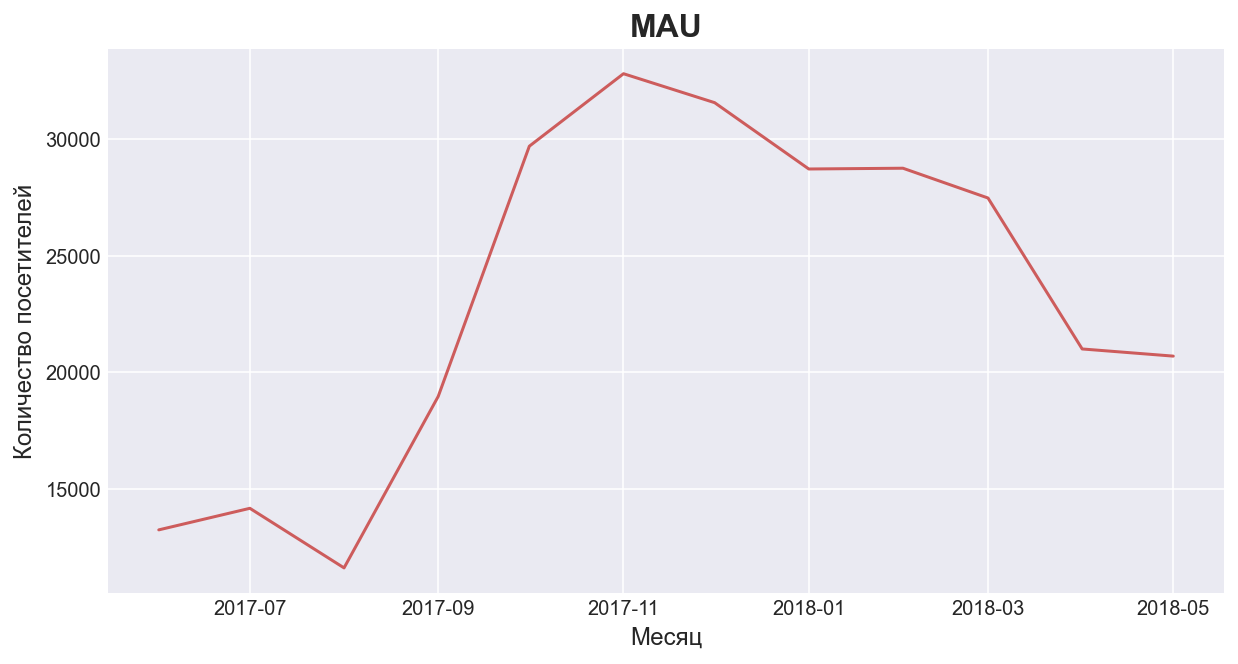

In [23]:
au_plot(mau, 'session_month', 'MAU', 'Месяц')

График снова подтверждает выводы, которые мы сделали из прошлых этапов. Люди чаще ищут билеты на мероприятия в холодное время года.

***

Посчитаем среднее количество посещений сайта в день для одного пользователя. Для этого сгруппируем данные по дате, посчитаем все заходы на сайт и уникальные.

In [24]:
visits_daily = visits.groupby('session_date').agg({'uid': ['count', 'nunique']}).reset_index()
visits_daily.columns = ['session_date', 'daily_sessions', 'daily_users']

Разделим число посещений на число пользователей, чтобы получить столбец со средним количеством заходов на сайт одного пользователя для каждого дня.

In [25]:
visits_daily['daily_sessions_per_user'] = visits_daily['daily_sessions'] / visits_daily['daily_users']

In [26]:
visits_daily.tail(3)

,session_date,daily_sessions,daily_users,daily_sessions_per_user
361,2018-05-29,1035,948,1.091772
362,2018-05-30,1410,1289,1.093871
363,2018-05-31,2256,1997,1.129695


Разделим сумму ежедневных заходов за всё время на количество ежедневных пользователей, чтобы получить среднее количество заходов на сайт в день за весь период.

In [27]:
visits_daily['daily_sessions'].sum() / visits_daily['daily_users'].sum()

1.0874136559064957

В среднем пользователи заходят на сайт 1 раз в день. Это неудивительно, ведь им нужно просто посмотреть предстоящие мероприятия и, возможно, купить на них билеты.  
  
Посмотрим на изменение метрики во времени.

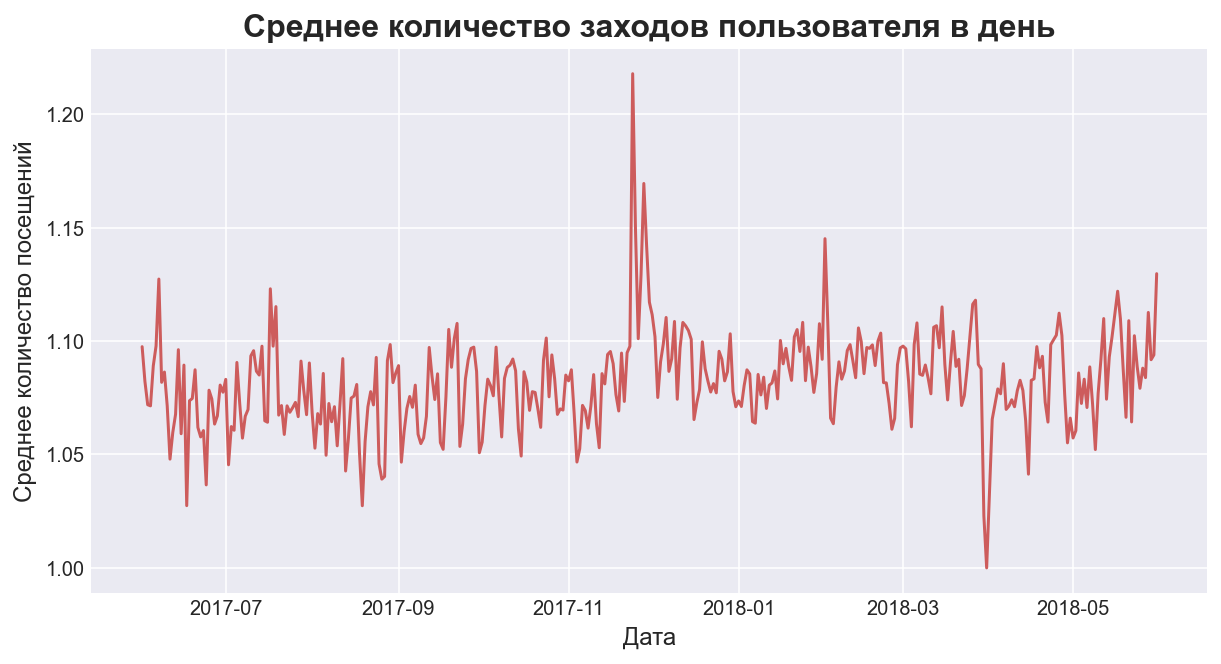

In [28]:
plt.figure(figsize=(10,5))
sns.lineplot(
    x='session_date',
    y='daily_sessions_per_user',
    data=visits_daily,
    color='indianred'
)
plt.title('Среднее количество заходов пользователя в день', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Среднее количество посещений', fontsize=12);

Среднее количество посещений сайта пользователем в день почти не меняется и на протяжении всего периода находится **между 1,05 и 1,1.** Также видны уже знакомые нам пик 24 ноября 2017-го и спад 31 марта 2018-го.

<a id="asl"></a>

### ASL

Чтобы посчитать среднюю продолжительность пользовательской сессии, вычтем время начала сессии из времени конца.

In [29]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Прежде чем считать среднее, взглянем на распределение. Это поможет выбрать правильную функцию для расчёта среднего значения.

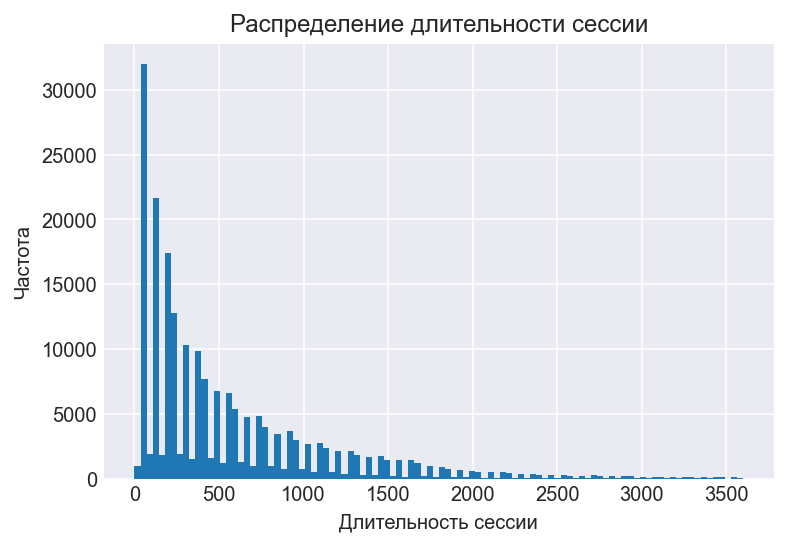

In [30]:
mean_sessions = visits.groupby('uid', as_index=False)['session_duration'].mean()
mean_sessions.query('session_duration>0')['session_duration'].hist(bins=100, range=(0, 3600))
plt.title('Распределение длительности сессии')
plt.xlabel('Длительность сессии')
plt.ylabel('Частота');

Распредение имеет вид геометрического. В качестве средней меры лучше выбрать медиану.

In [31]:
mean_sessions['session_duration'].median()

300.0

Медианное время — 5 минут. Значит, половина пользователей проводит на сайте меньше 5 минут, а половина — больше.

<a id="rr"></a>

### Retention Rate

Рассчитаем Retention Rate. Для этого применим когортный анализ. Для начала найдём дату первого захода на сайт для каждого пользователя.

In [32]:
first_visits = visits.groupby('uid')['start_ts'].min().reset_index()
first_visits.columns = ['uid', 'first_visit']

Добавим данные о первом посещении к нашей таблице методом `merge`.

In [33]:
visits = visits.merge(first_visits, on='uid')

Выделим месяц из дат первого посещения и всех посещений.

In [34]:
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

Разделим пользователей на когорты: сгруппируем данные по дате первого посещения и дате сессии, посчитаем количество пользователей, которые заходили на сайт в эти месяцы.

In [35]:
cohorts = visits.groupby(['first_visit_month', 'visit_month']).agg({'uid': 'nunique'}).reset_index()
cohorts = cohorts.rename(columns={'uid': 'total_visits'})

Для каждой когорты посчитаем её *lifetime*.

In [36]:
cohorts['lifetime'] = (
    ((cohorts['visit_month'] - cohorts['first_visit_month'])
     / np.timedelta64(1, 'M'))
    .round()
    .astype('int')
)

От даты когорты оставим только год и месяц.

In [37]:
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

Найдём первоначально количество пользователей в когортах.

In [38]:
users_in_cohorts = cohorts.groupby('first_visit_month')['total_visits'].max().reset_index()
users_in_cohorts = users_in_cohorts.rename(columns={'total_visits': 'total_visits_1st_month'})

Добавим полученные данные в таблицу с когортами.

In [39]:
cohorts = cohorts.merge(users_in_cohorts, on='first_visit_month')

Посчитаем **Retention rate** каждой когорты.

In [40]:
cohorts['retention_rate'] = cohorts['total_visits'] / cohorts['total_visits_1st_month']

In [41]:
cohorts.tail(3)

,first_visit_month,visit_month,total_visits,lifetime,total_visits_1st_month,retention_rate
75,2018-04,2018-04-01,15709,0,15709,1.00000
76,2018-04,2018-05-01,760,1,15709,0.04838
77,2018-05,2018-05-01,15273,0,15273,1.00000


Построим сводную таблицу, в которой каждой когорте и её *lifetime* будет соответствовать коэффициент удержания на данный месяц.

In [42]:
cohorts_ret_rate = (
    cohorts
    .query('lifetime>0') # посмотрим на когорты, начиная со второго месяца — в первый месяц везде будет 100%, это сильно исказит визуализацию
    .pivot_table(
        index='first_visit_month',
        columns='lifetime',
        values='retention_rate'
    )
)

Для визуализации данных когортного анализа напишем функцию.

In [43]:
def heatmap(data, fmt, title):
    '''Возвращает тепловую карту результата когортного анализа
    Параметры:
    data (DataFrame) — сводная таблица когортного анализа
    fmt (str) — формат чисел в ячейках
    title (str) — заголовок'''
    plt.figure(figsize=(10,6)) # задаем размер фигуры
    plt.title( # задаем заголовок
        title,
        fontsize=18,
        fontweight='bold',
        color='darkmagenta')
    sns.heatmap( # рисуем тепловую карту
        data,
        annot=True, # выводим числа на ячейки
        fmt=fmt, # задаем формат вывода чисел
        cmap='flare') # задаем цветовую схему
    plt.xlabel( # подпись оси X
        'Lifetime',
        fontsize=14)
    plt.ylabel( # подпись оси Y
        'Cohort',
        fontsize=14);

При помощи функции изобразим тепловую карту коэффициента удержания.

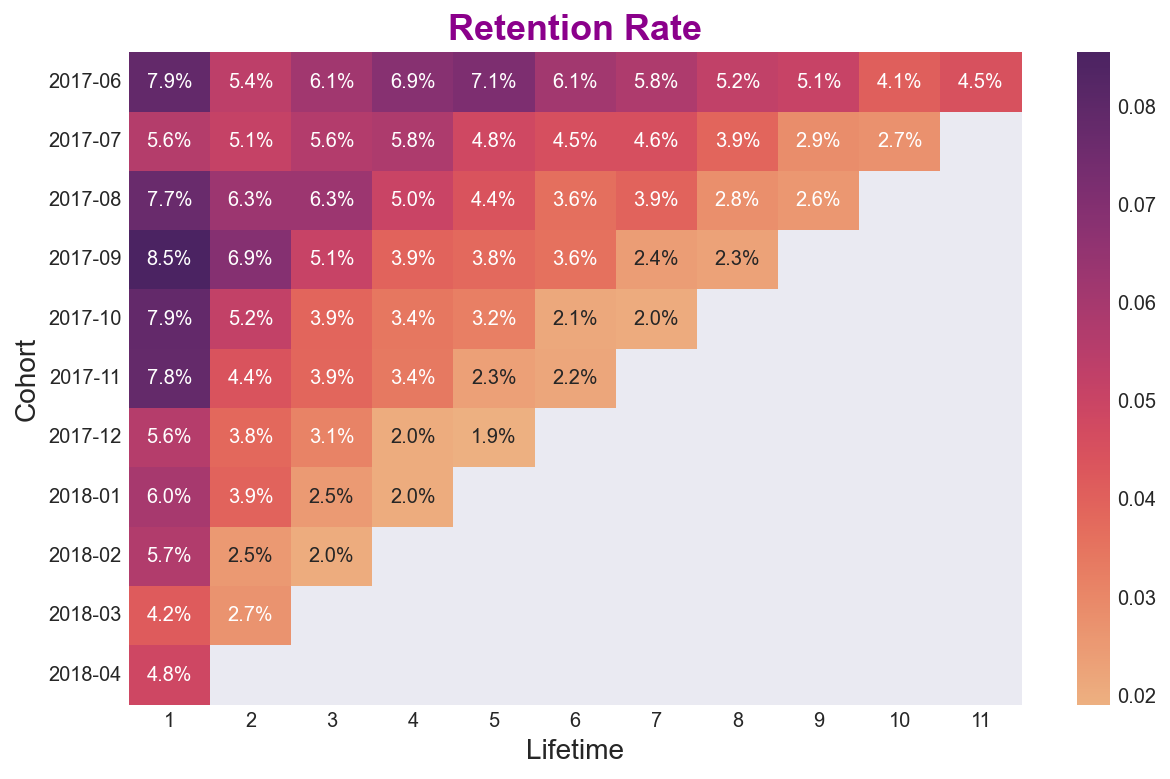

In [44]:
heatmap(cohorts_ret_rate, '.1%', 'Retention Rate')

После первого месяца больше 90% пользователей сайта уходят. Скорее всего, они один раз что-то покупают (или совсем ничего не покупают) и больше никогда не возвращаются.  
  
В то же время начиная со второго месяца остаются постоянные пользователи, которые почти не уходят со временем. Многие регулярно возвращаются спустя несколько месяцев (как пользователи первой и третьей когорты).  
  
Также видно, что начиная с декабря 2017 года коэффициент удержания во второй месяц жизни когорт снижается с примерно 8% до 5-6%. Возможно, это связано с наступлением зимы (больше людей интересуются сайтом, но немногие из них становятся регулярными пользователями).

Посчитаем средний Retention Rate для всех когорт на второй месяц жизни.

In [45]:
(cohorts_ret_rate[1].mean() *100).round(2)

6.52

Среднее значение — около 6,5%, но выше мы выяснили, что начиная в декабря 2017-го наблюдается снижение коэффициента.

### Вывод

Мы изучили пользовательские метрики и можем сделать следующие выводы:
1. Сайт более популярен в холодное время года, в теплый сезон активность пользователей снижается. Люди предпочитают отдых на открытом воздухе и реже ходят в театры и кино.
2. 31 марта 2018 года на сайт заходил 1 пользователь. Или сломался счётчик, или не работал сайт. В любом случае, с этим нужно отдельно разобраться.
3. В день каждый пользователь в среднем заходит на сайт 1 раз и проводит на нём 1 минуту.
4. Больше 90% пользователей не возвращаются на сайт после первого месяца (а скорее всего и после первого посещения). Они однажды заходят, а затем уходят навсегда. Остальные пользователи становятся постоянными и регулярно возвращаются. Начиная со второго месяца коэффициент удержания снижается достаточно медленно.
5. Начиная с декабря 2017 года коэффициент удержания снижается у всех когорт. Возможно, это сезонное снижение, но лучше это проверить.

<a id="atfp"></a>

### Среднее время от первого визита до покупки

Посчитаем среднее время от первого визита на сайт до первого заказа. Для этого создадим таблицу, где каждому пользователю будет соответствовать время его первого заказа.

In [46]:
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders = first_orders.rename(columns={'buy_ts': 'first_order'})

Полученную таблицу присоединим к таблице с первыми посещениями.

In [47]:
visits_to_orders = first_orders.merge(first_visits, on='uid')

Вычтем из даты первого заказа дату первого визита на сайт.

In [48]:
visits_to_orders['time_to_purchase'] = visits_to_orders['first_order'] - visits_to_orders['first_visit']

Чтобы выбрать правильную меру центральной тенденции, построим гистограмму.

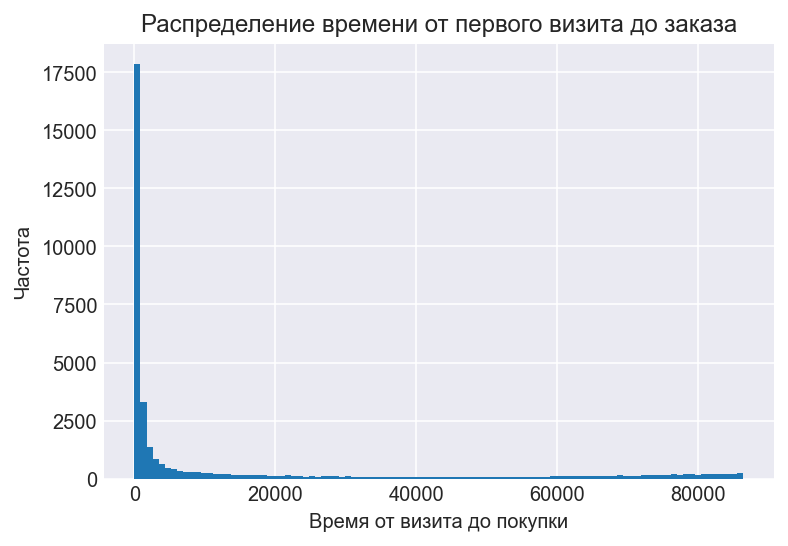

In [49]:
visits_to_orders['time_to_purchase'].dt.seconds.hist(bins=101)
plt.title('Распределение времени от первого визита до заказа')
plt.xlabel('Время от визита до покупки')
plt.ylabel('Частота');

Снова лучше всего нам подойдёт медиана. Высокие значения времени от первого посещения до заказа могут исказить среднее.

In [50]:
visits_to_orders['time_to_purchase'].median()

Timedelta('0 days 00:16:00')

Медианное время от первого захода на сайт до первого заказа — 16 минут. Значит, половине пользователей хватает 16 минут с первого визита на сайт, чтобы принять решение о покупке.

<a id="aoc"></a>

### Среднее количество заказов на одного пользователя

Посчитаем среднее количество заказов на одного пользователя по когортам. Для этого присоединим таблицу с первыми заказами к общей таблице заказов.

In [51]:
orders_cohorts = orders.merge(first_orders, on='uid')

Так же, как и для определения коэффициента удержания, сформируем когорты пользователей.

In [52]:
orders_cohorts['first_order_month'] = orders_cohorts['first_order'].astype('datetime64[M]')
orders_cohorts['order_month'] = orders_cohorts['buy_ts'].astype('datetime64[M]')

In [53]:
orders_cohorts.tail(3)

,buy_ts,revenue,uid,first_order,first_order_month,order_month
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01 00:02:00,2018-06-01,2018-06-01


Для каждого месяца жизни каждой когорты рассчитаем количество заказов, количество покупателей и суммарную выручку.

In [54]:
orders_cohorts_grouped = (
    orders_cohorts
    .groupby(['first_order_month', 'order_month'])
    .agg({'uid': ['count', 'nunique'],
          'revenue': 'sum'})
    .reset_index()
)
orders_cohorts_grouped.columns = ['first_order_month', 'order_month', 'total_orders', 'customers', 'revenue']

Также найдём размер каждой когорты.

In [55]:
orders_cohorts_size = orders_cohorts.groupby('first_order_month')['uid'].nunique().reset_index()
orders_cohorts_size.columns = ['first_order_month', 'n_buyers']

Объединим данные, чтобы рассчитать среднее количество заказов в когорте.

In [56]:
orders_cohorts_extended = pd.merge(orders_cohorts_grouped, orders_cohorts_size, on='first_order_month')

Посчитаем среднюю выручку и среднее количество заказов на одного покупателя в когорте.

In [57]:
orders_cohorts_extended['revenue_per_customer'] = \
orders_cohorts_extended['revenue'] / orders_cohorts_grouped['customers']

orders_cohorts_extended['orders_per_customer'] = \
orders_cohorts_extended['total_orders'] / orders_cohorts_extended['n_buyers']

Расчитаем *lifetime* для каждой когорты.

In [58]:
orders_cohorts_extended['lifetime'] = (
    ((orders_cohorts_grouped['order_month'] - orders_cohorts_grouped['first_order_month'])
    / np.timedelta64(1, 'M'))
    .round()
    .astype('int')
)

In [59]:
orders_cohorts_extended.head(3)

,first_order_month,order_month,total_orders,customers,revenue,n_buyers,revenue_per_customer,orders_per_customer,lifetime
0,2017-06-01,2017-06-01,2354,2023,9557.49,2023,4.724414,1.163618,0
1,2017-06-01,2017-07-01,177,61,981.82,2023,16.095410,0.087494,1
2,2017-06-01,2017-08-01,174,50,885.34,2023,17.706800,0.086011,2


Кажется, после первого заказа большинство покупателей уходят навсегда. Совсем как с посещениями. Проверим это на графике.

In [60]:
orders_cohorts_extended['cohort_month'] = orders_cohorts_extended['first_order_month'].dt.strftime('%Y-%m')

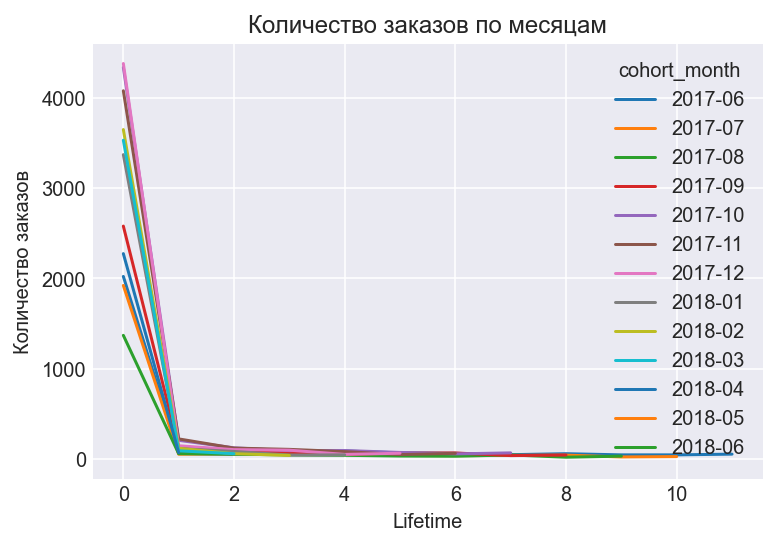

In [61]:
orders_cohorts_extended.pivot_table(
        index='lifetime',
        columns='cohort_month',
        values='customers').plot()
plt.title('Количество заказов по месяцам')
plt.xlabel('Lifetime')
plt.ylabel('Количество заказов');

Выводы подтвердились. После первой покупки большинство пользователей не возвращаются на сайт. Скорее всего, просто потому, что интересующие их мероприятия проходят редко. А возможно, им что-то не понравилось. Нужно это изучить отдельно. И подумать о том, как привлекать однажды купивших клиентов на сайт. Возможно, стоит улучшить рассылку.

Построим сводную таблицу по когортам и при помощи функции `heatmap` построим тепловую карту.

In [62]:
customer_average_orders = orders_cohorts_extended.pivot_table(
    index='cohort_month',
    columns='lifetime',
    values='orders_per_customer'
).cumsum(axis=1)

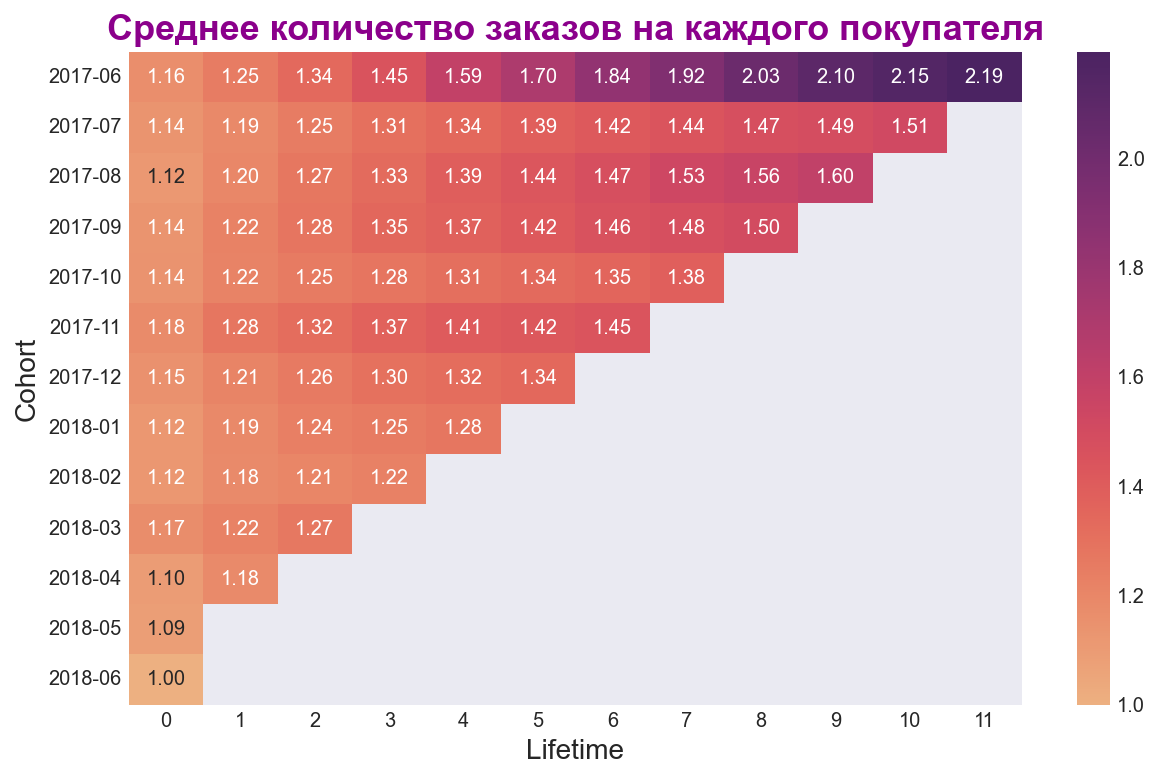

In [63]:
heatmap(customer_average_orders, '.2f', 'Среднее количество заказов на каждого покупателя')

Из графика видно, что после первого месяца среднее число заказов растёт очень медленно. Это связано с тем, что уходят те, кто сделал только один заказ, и остаются постоянные клиенты, которые покупают регулярно. Первая когорта покупает чаще всех, нужно дополнительно проанализировать, что именно вызвало такую лояльность.

Посчитаем среднее количество заказов за 6 месяцев.

In [64]:
customer_average_orders[5].mean()

1.4341911542792218

В среднем каждый покупатель одной когорты за 6 месяцев делает почти полтора заказа.

<a id="arpu"></a>

### Средний чек

Посчитаем величину среднего чека. Для этого таблицу с заказами сгруппируем по дате заказа и посчитаем количество заказов и сумму выручки по месяцам.

In [65]:
aov = orders_cohorts.groupby('order_month').agg({'revenue': 'sum', 'uid': 'count'}).reset_index()
aov.columns = ['order_month', 'monthly_revenue', 'monthly_orders']

Поделим месячную выручку на количество заказов, чтобы получить средний чек.

In [66]:
aov['average_order_value'] = aov['monthly_revenue'] / aov['monthly_orders']

In [67]:
aov['order_month'] = aov['order_month'].dt.strftime('%Y-%m')

Построим график изменения величины среднего чека по месяцам.

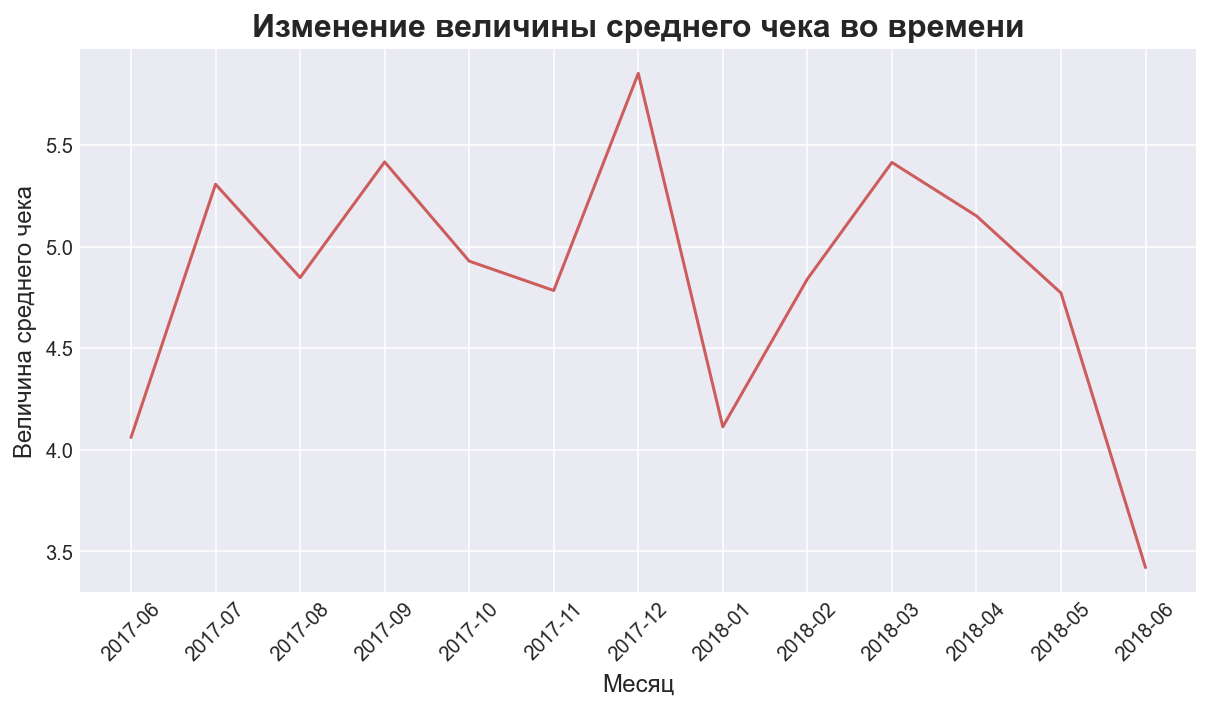

In [68]:
plt.figure(figsize=(10,5))
sns.lineplot(
    x='order_month',
    y='average_order_value',
    data=aov,
    color='indianred'
)
plt.xticks(rotation=45)
plt.title('Изменение величины среднего чека во времени', fontsize=16, fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Величина среднего чека', fontsize=12);

Судя по графику, средний чек уменьшается в январе и июне. Снижение в январе, возможно, связано с новогодними праздниками. 

<a id="ltv"></a>

### LTV

Посчитаем LTV каждой когорты, поделив выручку на количество покупателей в когортах.

In [69]:
orders_cohorts_extended['ltv'] = orders_cohorts_extended['revenue'] / orders_cohorts_extended['n_buyers']

In [70]:
orders_cohorts_extended['first_order_month'] = orders_cohorts_extended['cohort_month']

In [71]:
orders_cohorts_extended.tail(3)

,first_order_month,order_month,total_orders,customers,revenue,n_buyers,revenue_per_customer,orders_per_customer,lifetime,cohort_month,ltv
76,2018-04,2018-05-01,195,69,1209.92,2276,17.535072,0.085677,1,2018-04,0.531599
77,2018-05,2018-05-01,3249,2988,13925.76,2988,4.660562,1.087349,0,2018-05,4.660562
78,2018-06,2018-06-01,1,1,3.42,1,3.420000,1.000000,0,2018-06,3.420000


Строим сводную таблицу по когортам.

In [72]:
ltv_table = (
    orders_cohorts_extended
    .pivot_table(
        index='first_order_month',
        columns='lifetime',
        values='ltv'
    )
    .cumsum(axis=1)
)

Выделим только те когорты, которые пользуются сайтом не менее 6 месяцев.

In [73]:
ltv_old_cohorts = ltv_table[~ltv_table[5].isna()]

Посчитаем их средний LTV.

In [74]:
ltv_old_cohorts[5].mean()

7.969052630207353

В среднем каждый пользователь этих когорт принес за полгода почти 8 у.е. Посмотрим на тепловую карту.

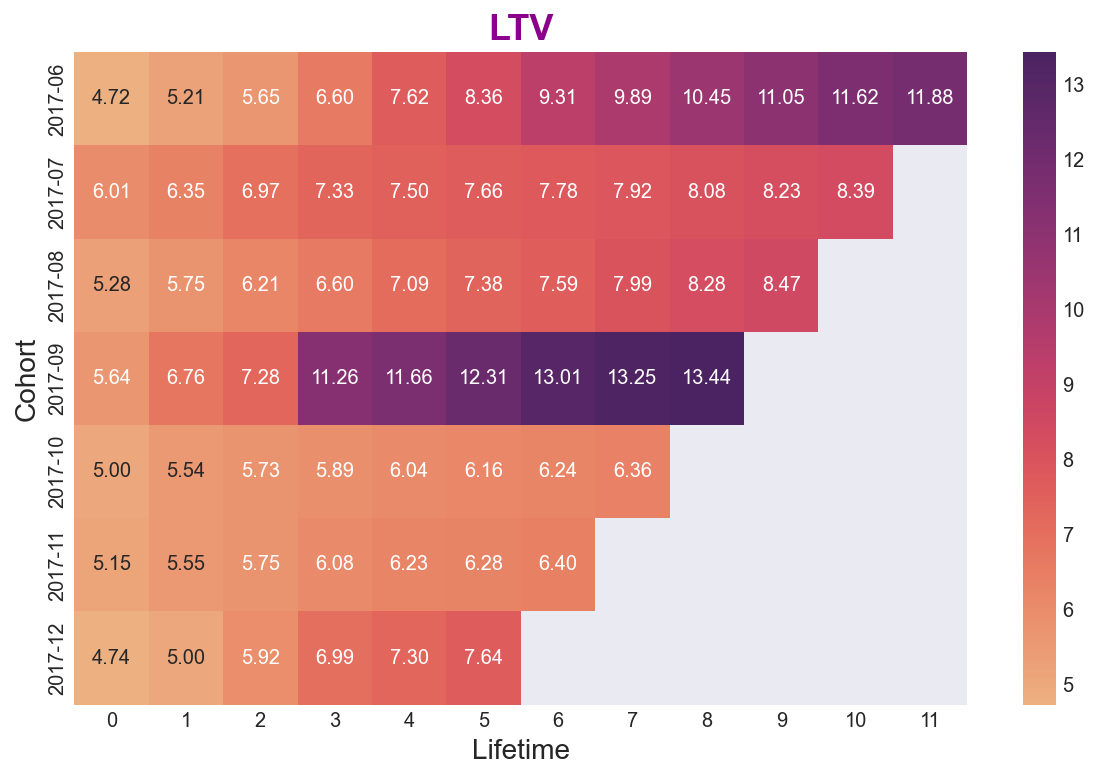

In [75]:
heatmap(ltv_old_cohorts, '.2f', 'LTV')

В лидерах снова первая когорта, к ней также добавилась четвертая. Стоит дополнительно изучить их, чтобы понять, что на это повлияло.  
  
Когорты октября и ноября 2017 года почти перестали приносить выручку. Нужно подумать, как вернуть их лояльность.

### Вывод

В этой части проекта можно сделать следующие выводы:
1. Анализ показал, что в среднем пользователи тратят 1 минуту от момента захода на сайт до заказа. Или у нас очень быстрый механизм оплаты, или что-то не так со счётчиком.
2. После первого заказа больше 90% пользователей не возвращаются. Стоит подумать над тем, как сделать их постоянными клиентами. Если они делали заказ, значит, у нас есть их электронная почта. Скорее всего на неё приходят наши рассылки. Нужно попробовать их усовершенствовать, например, персонализировать на основе заказа пользователя.
3. Первая когорта (июнь-2017) покупает на сайте чаще всех, вместе с четвертой (сентябрь-2017) они приносят больше всех выручки. Не лишним будет изучить их, чтобы понять, почему им понравилось у нас покупать, чтобы распространить их опыт на остальных пользователей.
4. Когорты октября и ноября 2017-го почти перестали приносить выручку. Их также нужно изучить, чтобы понять, что их оттолкнуло от дальнейших покупок.

<a id="romi"></a>

### Расходы на маркетинг

Посмотрим на расходы на маркетинг. Для каждого пользователя найдём «главный» источник его прихода на сайт. Им будет источник, из которого пользователь пришёл впервые. Для начала посмотрим, из каких источников пользователи чаще покупали. Для этого присоединим к таблице с визитами таблицу с первыми заказами.

In [76]:
visits_and_orders = visits.merge(first_orders, on='uid', how='left')

Создадим таблицу, в которой каждому пользователю будет соответствовать количество заказов, сделанных из определенного источника. Так мы определим тех, кто делал заказ, перейдя на сайт, а кто нет.

In [77]:
customers = visits_and_orders.groupby(['uid', 'source_id'])['first_order'].count().reset_index()

Создадим столбец, в котором будет информация о том, покупал у нас пользователь или нет.

In [78]:
customers['if_order'] = customers['first_order']!=0

Разделим таблицу на две — тех, кто хоть раз покупал, и тех, кто не покупал ни разу. Посчитаем для каждого источника трафика его долю в общем числе пользователей.

In [79]:
buyers = customers[customers['if_order']]['source_id'].value_counts(normalize=True).reset_index()
buyers['if_order'] = True

nonbuyers = customers[~customers['if_order']]['source_id'].value_counts(normalize=True).reset_index()
nonbuyers['if_order'] = False

Сложим таблицы, чтобы данные можно было визуализировать.

In [80]:
customers_normalized = pd.concat([buyers, nonbuyers])

Построим попарную столбчатую диаграмму. Для этого применим метод `barplot` библиотеки `seaborn`, а в качестве параметра `hue` передадим столбец `if_order`, чтобы сравнить делавших и неделавших заказ пользователей.

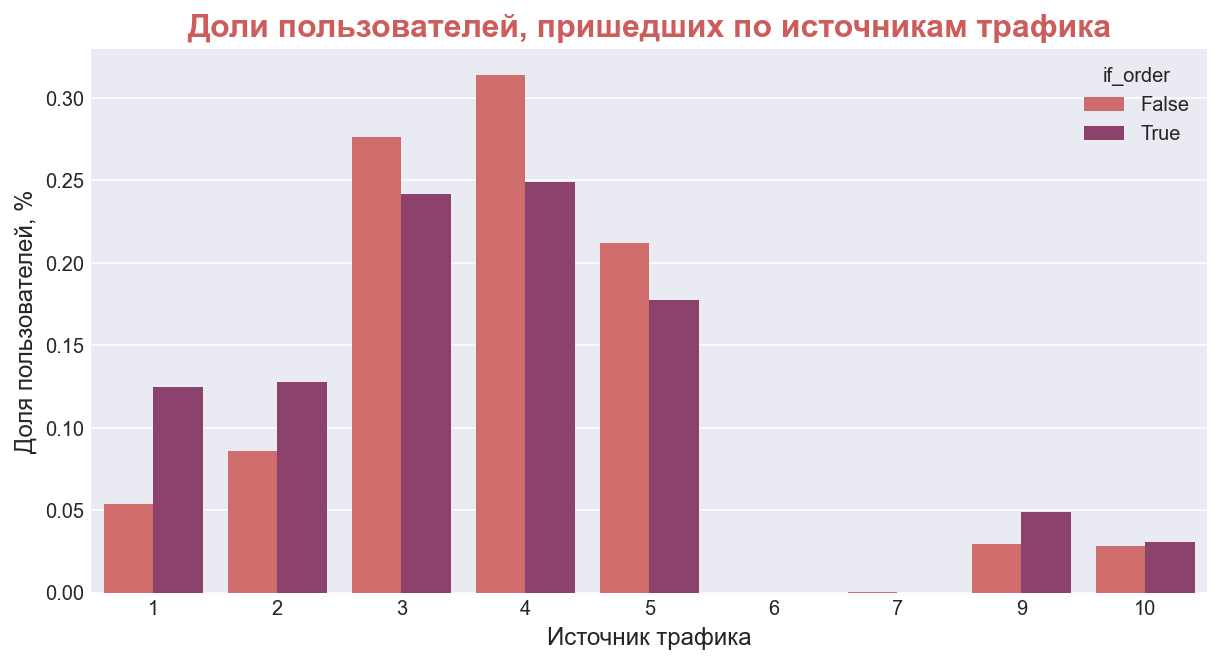

In [81]:
plt.figure(figsize=(10,5))
sns.barplot(
    x='index',
    y='source_id',
    hue='if_order',
    data=customers_normalized,
    palette='flare')
plt.title('Доли пользователей, пришедших по источникам трафика', fontsize=16, fontweight='bold', color='indianred')
plt.xlabel('Источник трафика', fontsize=12)
plt.ylabel('Доля пользователей, %', fontsize=12);

Из графика видно, что среди тех, кто **не делал** заказ, много пользователей, пришедших их 3, 4 и 5 источников. При этом люди, которые **стали покупателями**, относительно реже приходили из этих источников, но чаще (относительно тех, кто ни разу ничего не покупал) — из 1, 2 и 9. Можно предварительно предположить, что эти источники трафика более выгодные, и на них стоит тратить больше денег, а на 3, 4 и 5 — меньше.

Для расчёта месячных трат на источники трафика создадим столбец с месяцем в таблице с маркетинговыми расходами.

In [82]:
costs['month'] = costs['dt'].dt.strftime('%Y-%m')

In [83]:
costs.tail(3)

,source_id,dt,costs,month
2539,10,2018-05-29,11.32,2018-05
2540,10,2018-05-30,33.15,2018-05
2541,10,2018-05-31,17.60,2018-05


Построим сводную таблицу по месяцам и источникам, чтобы удобнее было визуализировать данные.

In [84]:
costs_pivot = (
    costs.pivot_table(
        index='source_id',
        columns='month',
        values='costs',
        aggfunc='sum')
)

Изобразим дашборд с тремя графиками: первым будет тепловая карта расходов на маркетинг по месяцам и источникам, вторым — график трат на все источники по месяцам, а третьим — столбчатая диаграмма с общими тратами на источники трафика.

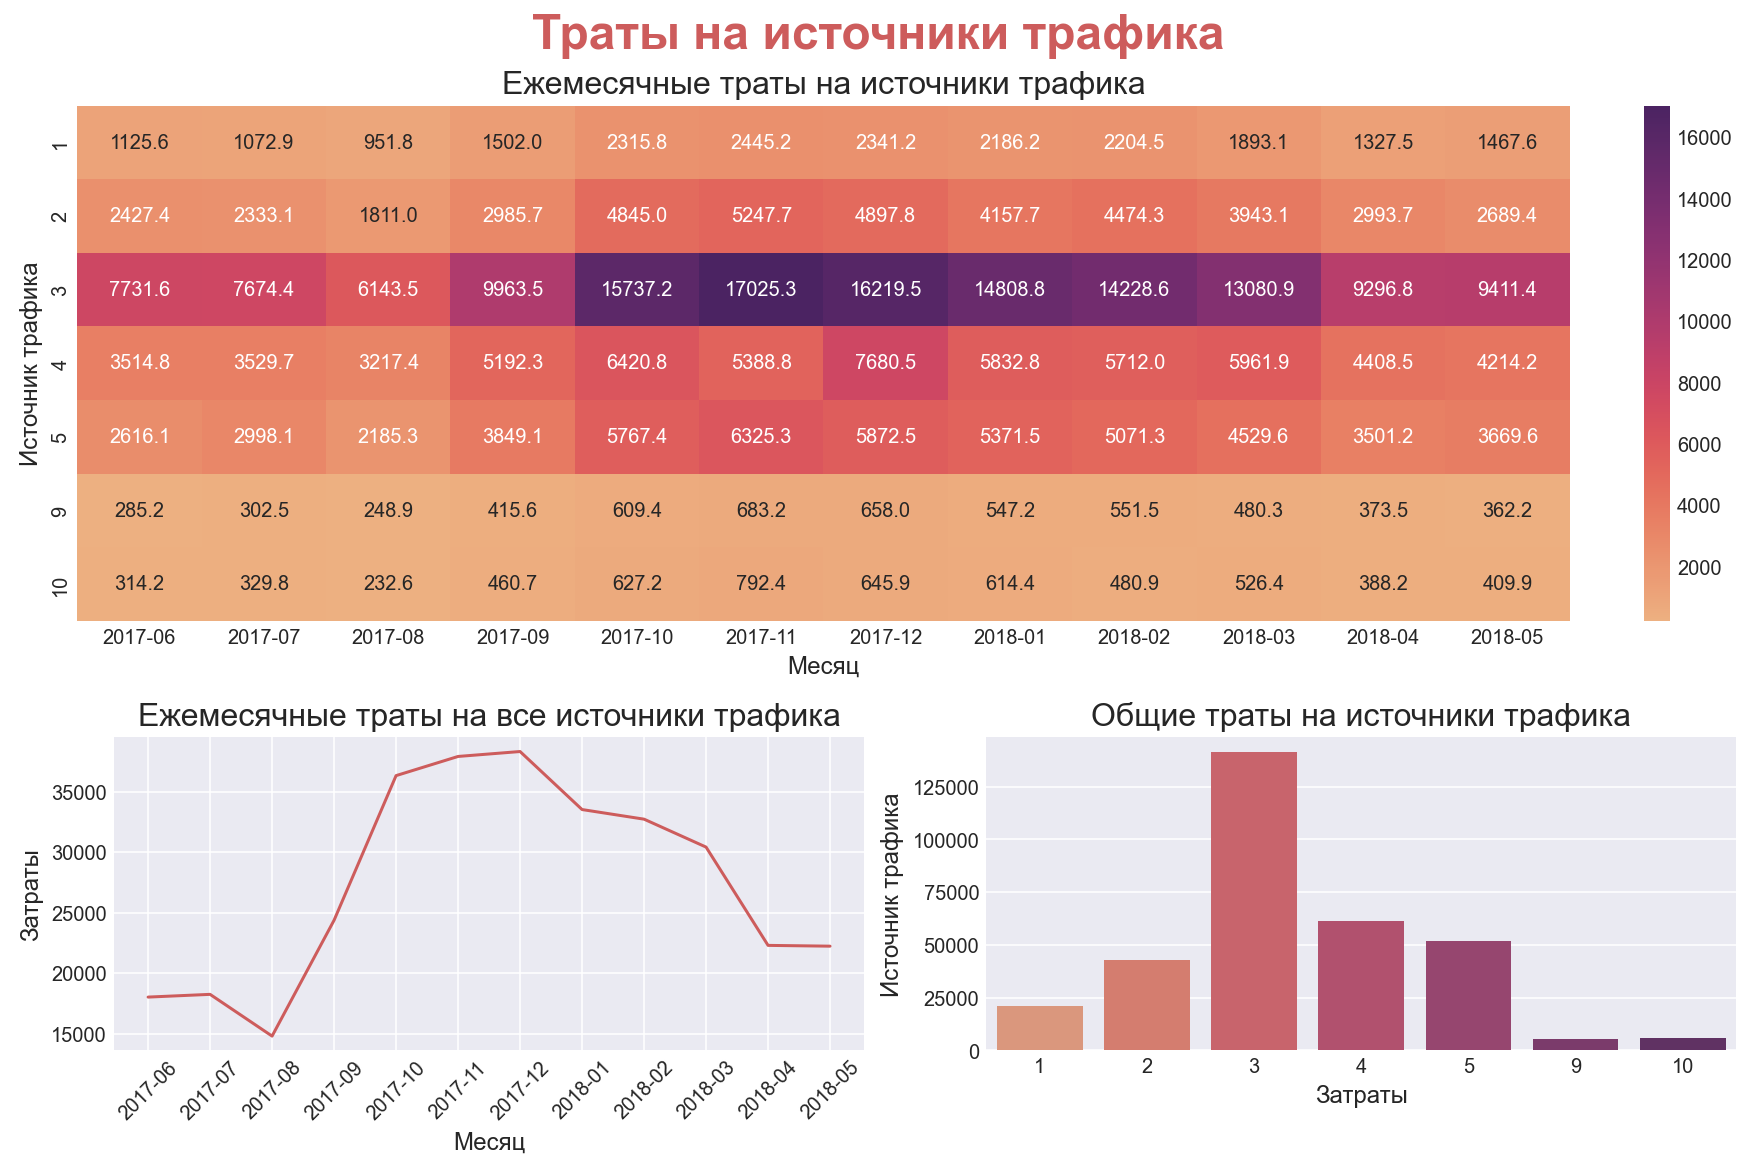

In [85]:
fig = plt.figure(constrained_layout=True, figsize=(12,8)) # создаем общую фигуру
fig.tight_layout()
fig.suptitle('Траты на источники трафика', fontsize=24, fontweight='bold', color='indianred') # подписываем её

subfigs = fig.subfigures(2, 1, height_ratios=[4, 3]) # делим на 2 подфигуры в соотношении 4:3
ax1 = subfigs[0].subplots(1,1)
sns.heatmap(costs_pivot, annot=True, fmt='.1f', cmap='flare') # на первой подфигуре рисуем тепловую карту
ax1.set_title('Ежемесячные траты на источники трафика', fontsize=16)
ax1.set_xlabel('Месяц', fontsize=12)
ax1.set_ylabel('Источник трафика', fontsize=12)

ax2 = subfigs[1].subplots(1,2) # вторую подфигуру делим на две области рисования

ax2[0].set_title('Ежемесячные траты на все источники трафика', fontsize=16)
for item in ax2[0].get_xticklabels():
    item.set_rotation(45)
sns.lineplot(data=costs_pivot.sum().reset_index(), x='month', y=0, ax=ax2[0], color='indianred')
ax2[0].set_xlabel('Месяц', fontsize=12)
ax2[0].set_ylabel('Затраты', fontsize=12)
# на первой области строим график трат на все источники по месяцам

ax2[1].set_title('Общие траты на источники трафика', fontsize=16)
sns.barplot(data=costs_pivot.sum(axis=1).reset_index(), x='source_id', y=0, ax=ax2[1], palette='flare')
ax2[1].set_xlabel('Затраты', fontsize=12)
ax2[1].set_ylabel('Источник трафика', fontsize=12);
# на второй — столбчатую диаграмму общих трат на источники трафика


Графики объясняют много всего:
1. На нижнем левом графике видно, что на рекламу тратили больше денег в холодное время года, чем в тёплое. Это логично, потому что люди чаще ходят в театры и кино, когда холодно. Поэтому на графиках пользовательской активности мы наблюдали увеличение к зиме и снижение к лету.
2. На 3, 4 и 5 источники тратят больше всего средств. Но люди, пришедшие из них, покупают относительно реже. В то же время на 1 и 9 источники тратится куда меньше денег, хотя люди оттуда становятся покупателями немного чаще.
3. На 3 источник тратят примерно половину всех денег, но приходящие из него пользователи часто ничего не покупают. Скорее всего, это контекстная реклама.
4. На все источники в холодное время года тратят примерно в 2 раза больше денег, чем в тёплое.

Посчитаем общий маркетинговый бюджет за весь период.

In [86]:
costs_pivot.sum().sum()

329131.62

За год потрачено почти 330 тысяч у.е. Теперь объединим информацию о тратах и заработках.

Из сводной таблицы трат вычислим траты за каждый месяц.

In [87]:
monthly_costs = costs_pivot.sum().reset_index()
monthly_costs.columns = ['month', 'total_costs']

Из сводной таблицы LTV — таблицу общего заработка с каждого покупателя когорты.

In [88]:
monthly_ltv = ltv_table.max(axis=1).reset_index()
monthly_ltv.columns = ['month', 'ltv']

В таблице с размерами когорт приведем иформацию о месяце к виду «год-месяц».

In [89]:
orders_cohorts_size['first_order_month'] = orders_cohorts_size['first_order_month'].dt.strftime('%Y-%m')
orders_cohorts_size.columns = ['month', 'n_buyers']

Создадим таблицу с метриками: объединим прошлые три таблиы в одну.

In [90]:
metrics = orders_cohorts_size.merge(monthly_costs, on='month')
metrics = metrics.merge(monthly_ltv, on='month')

Посчитаем среднюю стоимость привлечения клиента: поделим месячные затраты на количество покупателей.

In [91]:
metrics['cac'] = metrics['total_costs'] / metrics['n_buyers']

Также рассчитаем общую величину возврата на инвестиции.

In [92]:
metrics['romi'] = metrics['ltv'] / metrics['cac']

In [93]:
metrics

,month,n_buyers,total_costs,ltv,cac,romi
0,2017-06,2023,18015.00,11.879234,8.905091,1.333982
1,2017-07,1923,18240.59,8.386854,9.485486,0.884178
2,2017-08,1370,14790.54,8.471723,10.796015,0.784708
3,2017-09,2581,24368.91,13.435227,9.441654,1.422974
4,2017-10,4340,36322.88,6.360242,8.369327,0.759947
5,2017-11,4081,37907.88,6.395244,9.288870,0.688485
6,2017-12,4383,38315.35,7.639913,8.741809,0.873951
7,2018-01,3373,33518.52,4.940151,9.937302,0.497132
8,2018-02,3651,32723.03,4.587921,8.962758,0.511887
9,2018-03,3533,30415.27,5.455253,8.608907,0.633675


Уже по этой таблице видно, что большинство когорт не окупились. Позже подробнее взглянем на них в разрезе lifetime и источников.  
  
А вот стоимость привлечения почти не меняется и находится на уровне 8-10 у.е.

In [94]:
costs['costs'].sum() / orders['uid'].nunique()

9.011626098622786

Средняя стоимость привлечения одного клиента — 9 у.е.

Теперь посмотрим на CAC и ROMI в разрезе lifetime когорт. Объединим таблицу с расходами с таблицей с заказами по когортам, посчитаем метрики.

In [95]:
report_new = orders_cohorts_extended.merge(monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['total_costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']

In [96]:
report_new.tail(3)

,first_order_month,order_month,total_orders,customers,revenue,n_buyers,revenue_per_customer,orders_per_customer,lifetime,cohort_month,ltv,month,total_costs,cac,romi
75,2018-04,2018-04-01,2495,2276,10600.69,2276,4.657597,1.096221,0,2018-04,4.657597,2018-04,22289.38,9.793225,0.475594
76,2018-04,2018-05-01,195,69,1209.92,2276,17.535072,0.085677,1,2018-04,0.531599,2018-04,22289.38,9.793225,0.054282
77,2018-05,2018-05-01,3249,2988,13925.76,2988,4.660562,1.087349,0,2018-05,4.660562,2018-05,22224.27,7.437841,0.626601


Построим сводную таблицу и визуализируем.

In [97]:
report_new_pivot = (
    report_new
    .pivot_table(
        index='first_order_month',
        columns='lifetime',
        values='romi'
    )
    .cumsum(axis=1)
)

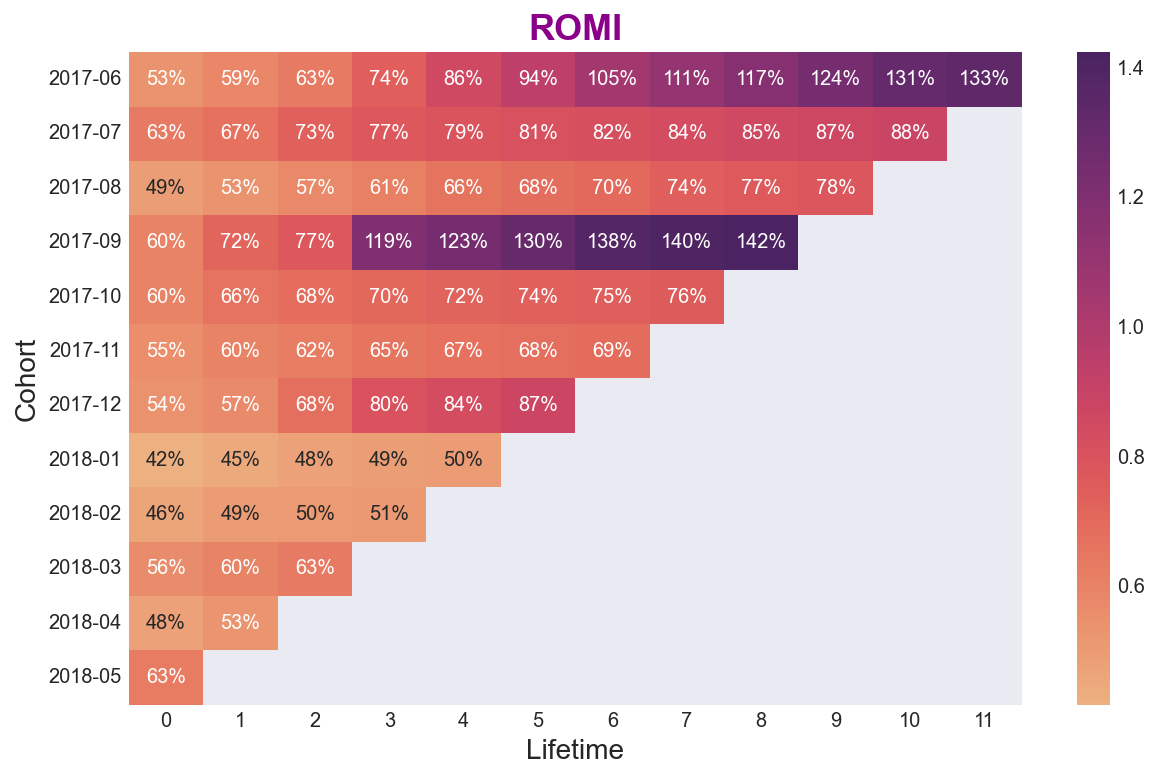

In [98]:
heatmap(report_new_pivot, '.0%', 'ROMI')

Снова в лидерах когорты июня и сентября 2017 года. Пока что только они полностью себя окупили. Совершенно точно нужно их подробно изучить, чтобы понять, что на это повлияло. Также есть шанс стать прибыльной у когорты декабря 2017 года и, возможно, марта-2018.

Теперь посчитаем CAC для каждого источника отдельно. Для этого сгруппируем таблицу с визитами и заказами по пользователям и дате первого посещения и выберем источник первого визита.

In [99]:
users_from_sources = visits_and_orders.groupby(['uid', 'first_visit'])['source_id'].first().reset_index()
users_from_sources = users_from_sources.rename(columns={'source_id': 'main_source_id'})

Объединим данные с таблицей заказов.

In [100]:
orders = orders.merge(users_from_sources, on='uid')

Создадим таблицу с метриками в разрезе источников трафика: сгруппируем данные по источникам трафика и посчитаем количество заказов и покупателей и суммарную выручку.

In [101]:
sources_metrics = (
    orders
    .groupby('main_source_id')
    .agg({
        'uid': ['count', 'nunique'],
        'revenue': 'sum'})
    .reset_index())
sources_metrics.columns = ['main_source_id', 'orders', 'n_buyers', 'revenue']

Сгруппируем расходы по источнику и посчитаем сумму.

In [102]:
costs_by_sources = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()

Объединим данные.

In [103]:
sources_metrics = (
    sources_metrics
    .merge(
        costs_by_sources,
        left_on='main_source_id',
        right_on='source_id',
        how='outer')
)
sources_metrics = sources_metrics.drop(columns='source_id')

Посчитаем CAC для каждого источника. Выведем полученную таблицу и построим столбчатую диаграмму.

In [104]:
sources_metrics['cac'] = sources_metrics['costs'] / sources_metrics['n_buyers']

In [105]:
sources_metrics

,main_source_id,orders,n_buyers,revenue,costs,cac
0,1,6679,3743,38560.06,20833.27,5.565928
1,2,7734,4323,65152.26,42806.04,9.901929
2,3,10941,9138,44317.68,141321.63,15.465269
3,4,12246,9823,52479.75,61073.60,6.217408
4,5,9310,6839,40357.91,51757.10,7.567934
5,7,1,1,1.22,NaN,NaN
6,9,2053,1415,7076.98,5517.49,3.899286
7,10,1451,1241,4111.34,5822.49,4.691773


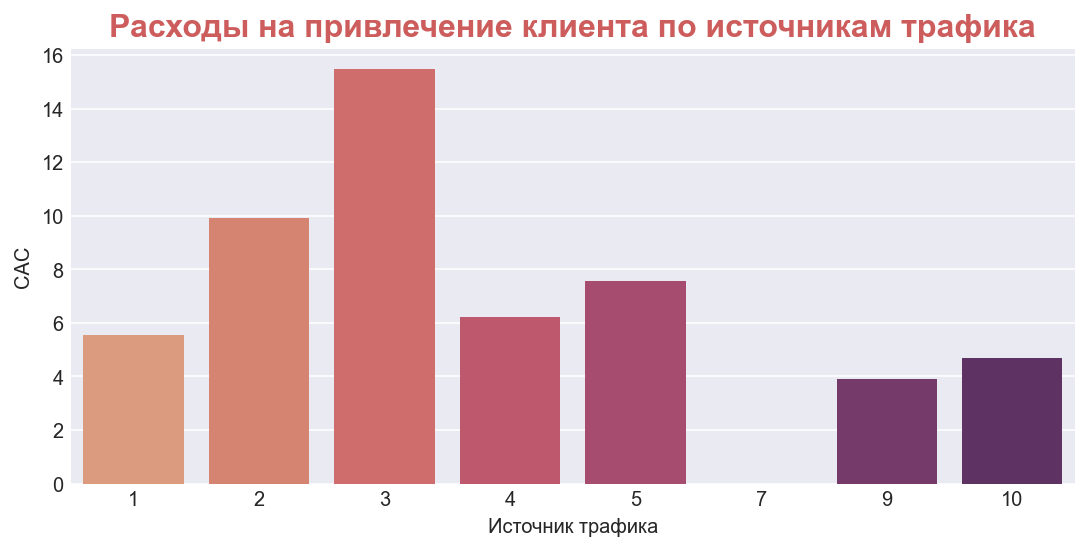

In [106]:
plt.figure(figsize=(9,4))
sns.barplot(
    x='main_source_id',
    y='cac',
    data=sources_metrics,
    palette='flare'
)
plt.title('Расходы на привлечение клиента по источникам трафика', fontsize=16, fontweight='bold', color='indianred')
plt.xlabel('Источник трафика')
plt.ylabel('CAC');

По-прежнему 3 источник — самый дорогой. На него тратят больше всего денег и дороже всего стоит привлечение одного клиента. А вот 2 с 4 поменялись местами: на 4 тратят больше денег, но каждый клиент стоит дешевле. Значит, это более эффективный канал. Также выгодными выглядят 1, 9 и 10 источники.

### ROMI

Теперь посчитаем ROMI для клиентов, пришедших из разных источников трафика. Для начала присоединим к талице заказов данные о первых заказах клиентов.

In [107]:
orders = orders.merge(first_orders, on='uid')
orders['first_order_month'] = orders['first_order'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.tail(3)

,buy_ts,revenue,uid,first_visit,main_source_id,first_order,first_order_month,order_month
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,3,2018-05-31 23:54:00,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,4,2018-05-31 23:56:00,2018-05-01,2018-05-01
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-05-31 23:59:00,4,2018-06-01 00:02:00,2018-06-01,2018-06-01


Разделим всех клиентов на когорты по источникам трафика. Произведем знакомый нам когортный анализ, но в разрезе источников.

In [108]:
cohorts_by_sources = (
    orders
    .groupby(['main_source_id',
              'first_order_month',
              'order_month'])
    .agg({
        'uid': ['count', 'nunique'], 
        'revenue': 'sum'})
    .reset_index()
)

cohorts_by_sources.columns = ['source_id', 'first_order_month', 'order_month', 'orders', 'n_buyers', 'revenue']

cohorts_by_sources['lifetime'] = (
    ((cohorts_by_sources['order_month'] - cohorts_by_sources['first_order_month'])
    / np.timedelta64(1, 'M'))
    .round()
    .astype('int')
)

cohorts_by_sources['first_order_month'] = cohorts_by_sources['first_order_month'].dt.strftime('%Y-%m')

In [109]:
cohorts_by_sources.tail(3)

,source_id,first_order_month,order_month,orders,n_buyers,revenue,lifetime
512,10,2018-04,2018-04-01,117,112,279.00,0
513,10,2018-04,2018-05-01,2,2,16.50,1
514,10,2018-05,2018-05-01,133,117,478.93,0


Взглянем на выручку, приносимую источниками трафика.

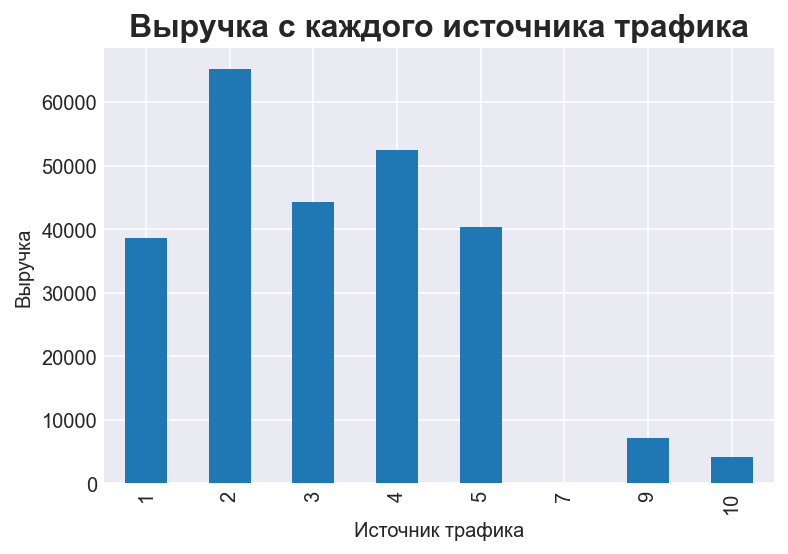

In [110]:
cohorts_by_sources.groupby('source_id')['revenue'].sum().plot(kind='bar')
plt.title('Выручка с каждого источника трафика', fontsize=16, fontweight='bold')
plt.xlabel('Источник трафика')
plt.ylabel('Выручка');

3 источник — первый по расходам, но лишь третий по выручке. Лучше всего себя показывают 2 и 4 источники.

Сгруппируем данные о расходах по источникам и месяцам. Это пригодится нам для расчёта ROMI по источникам.

In [111]:
costs_by_sources = costs.groupby(['source_id', 'month']).agg({'costs': 'sum'}).reset_index()

In [112]:
costs_by_sources.tail(3)

,source_id,month,costs
81,10,2018-03,526.41
82,10,2018-04,388.25
83,10,2018-05,409.86


При помощи цикла разделим получшенные таблицы о выручке и расходах по источникам трафика. Затем попарно объединим данные по каждому источнику. В каждой таблице посчитаем LTV, CAC и ROMI. Создадим сводные таблицы для визуализации данных о ROMI. Для каждого источника построим тепловую карту при помощи функции `heatmap`. Добавим данные о среднем ROMI за полгода для каждого источника трафика в отдельный список, чтобы отдельно проанализировать.

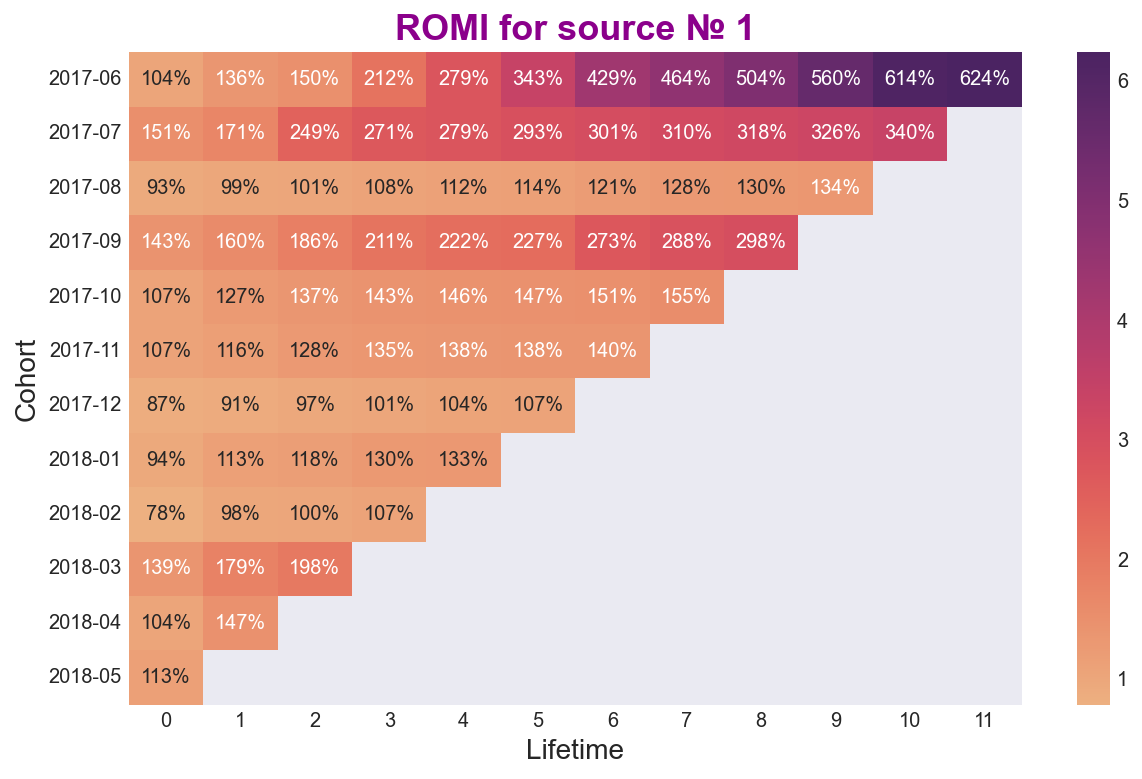

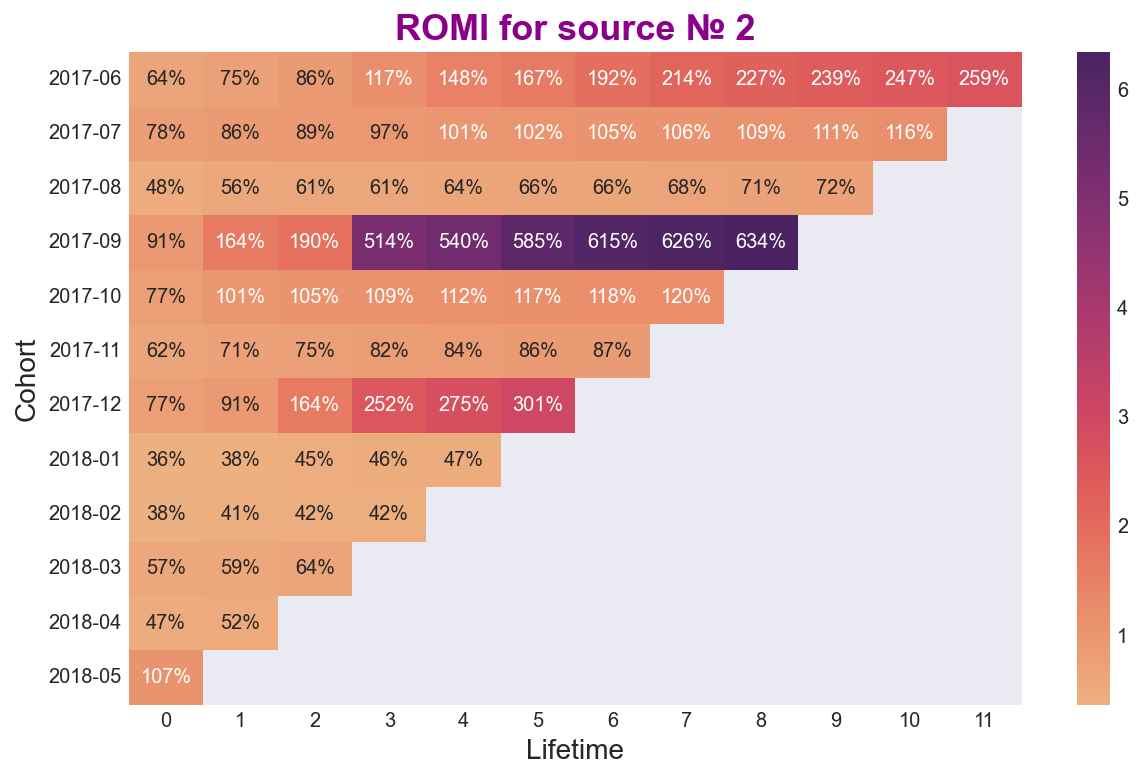

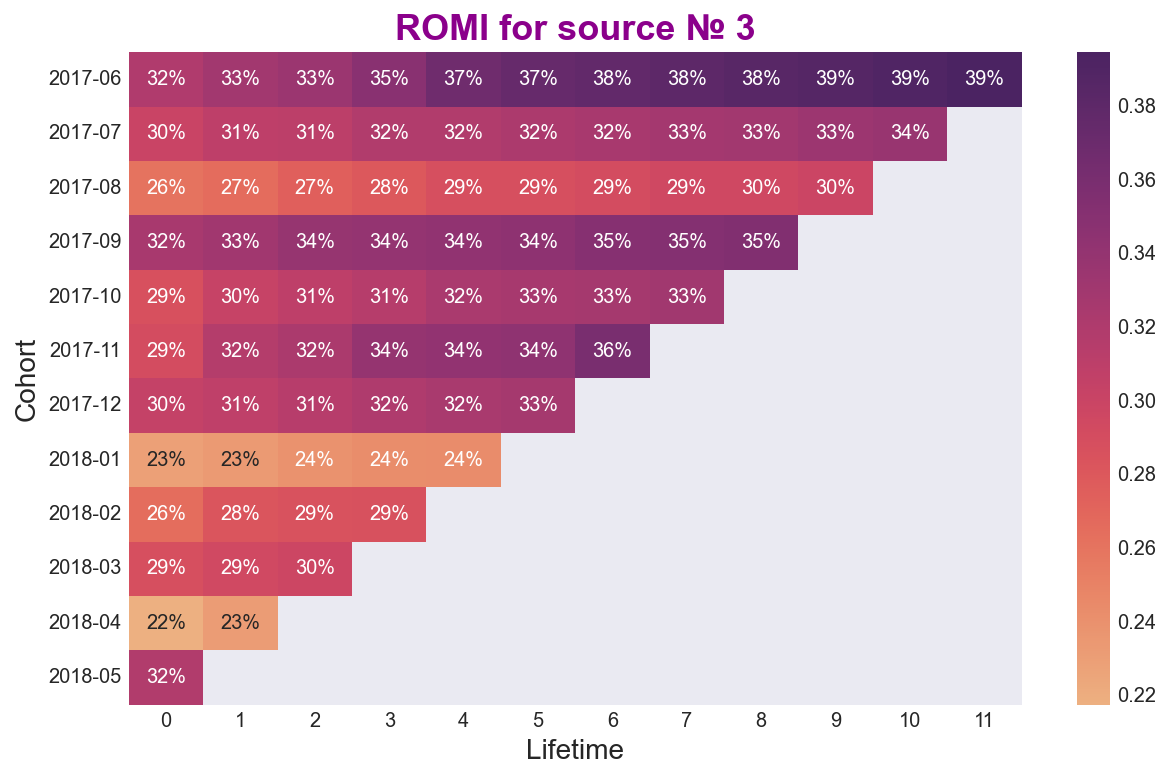

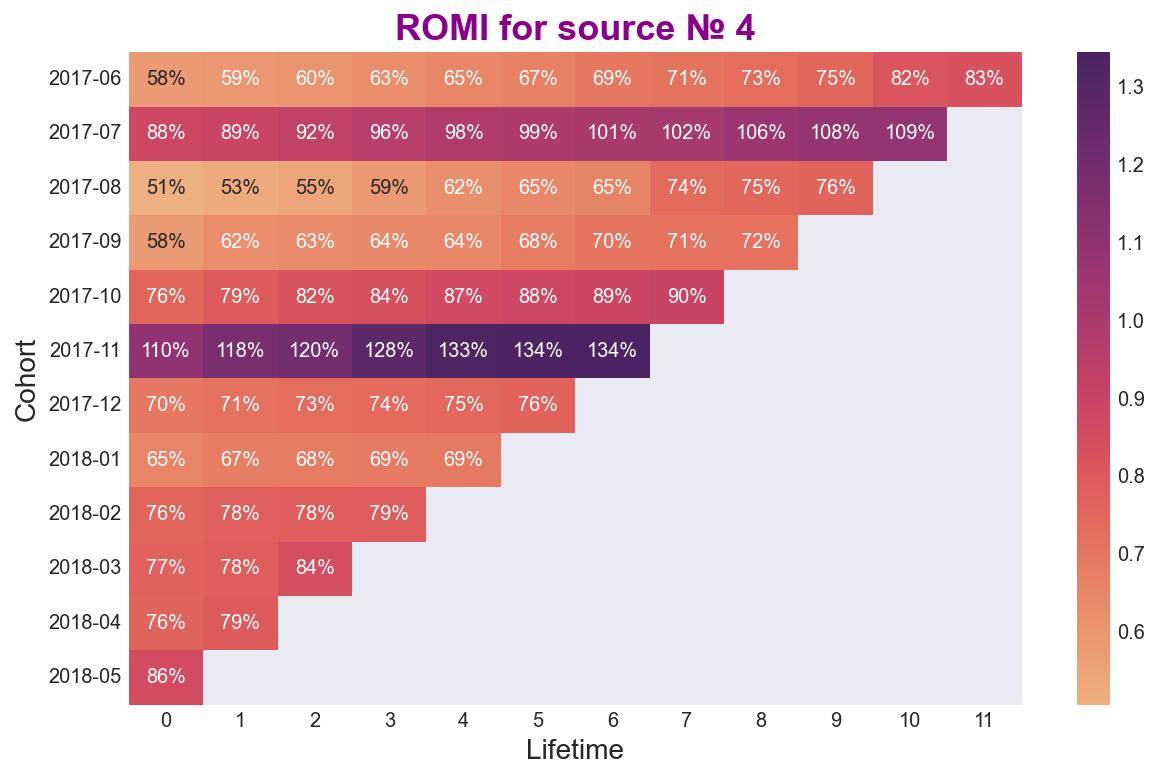

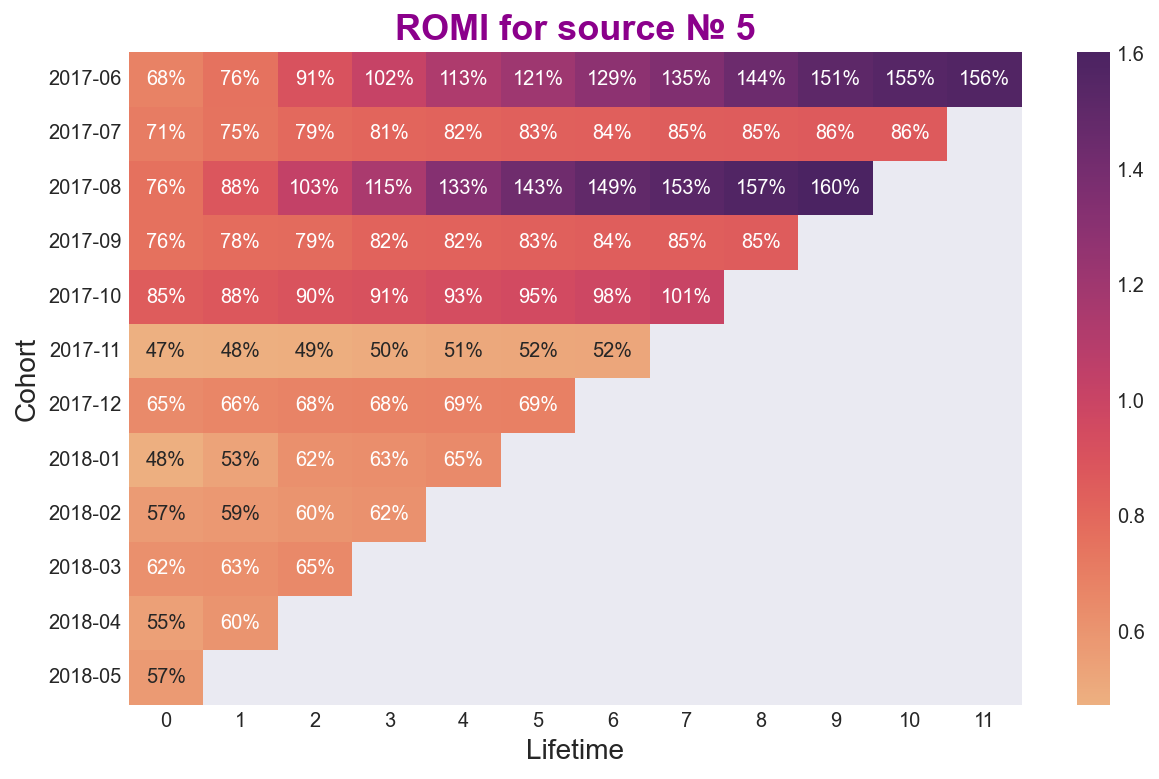

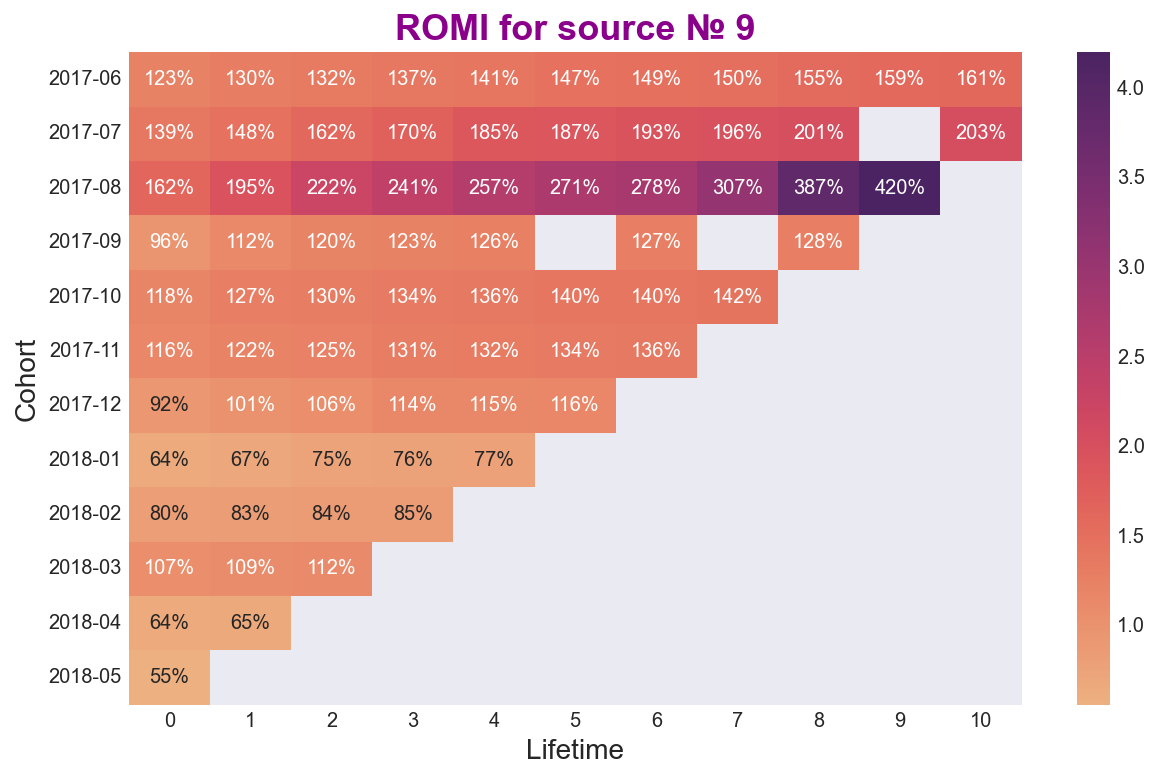

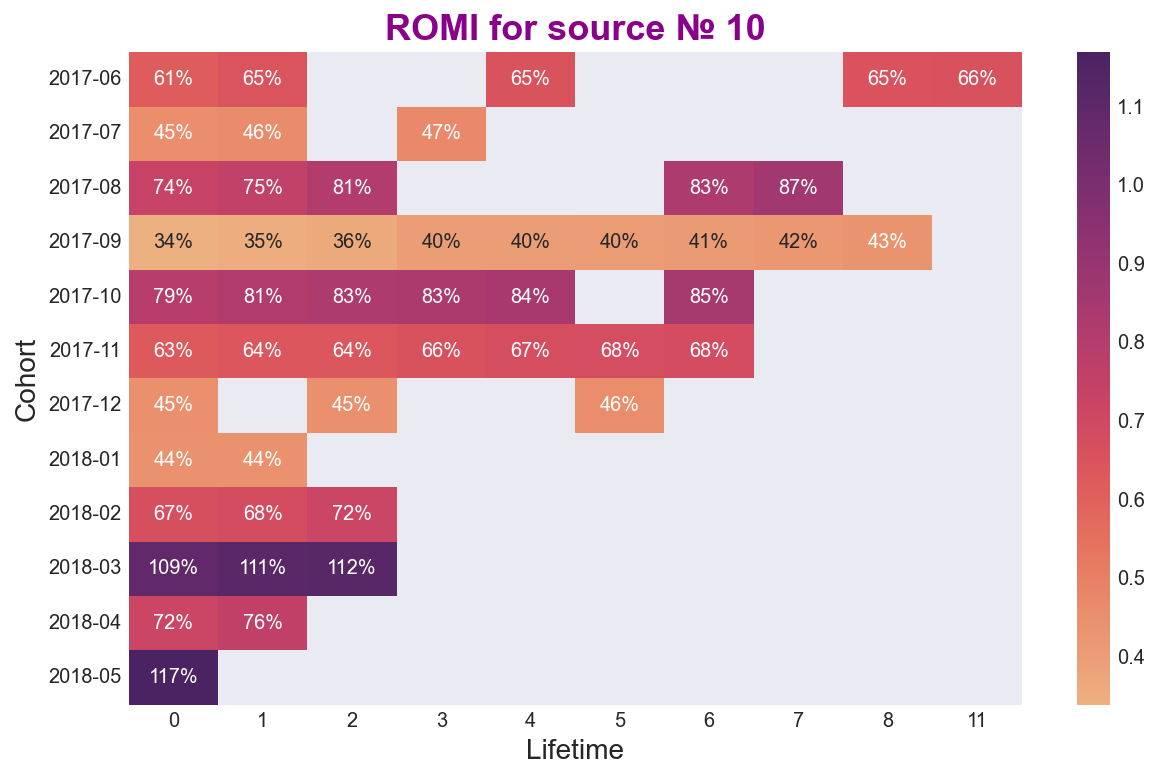

In [113]:
romi_by_sources = [] # создаем пустой список, в конце добавим в него нужные данные
for i in costs_by_sources['source_id'].unique(): # делим таблицы по источникам трат
    costs_by_sources_i = costs_by_sources[costs_by_sources['source_id']==i] # выбираем траты только на один источник
    cohorts_by_sources_i = cohorts_by_sources[cohorts_by_sources['source_id']==i] # и выручку с него же
    metrics_i = ( # объединяем данные о расходах и выручке
        cohorts_by_sources_i
        .merge(costs_by_sources_i,
               left_on='first_order_month',
               right_on='month'))
    metrics_i['ltv'] = metrics_i['revenue'] / metrics_i['n_buyers'] # считаем LTV
    metrics_i['cac'] = metrics_i['costs'] / metrics_i['n_buyers'] # CAC
    metrics_i['romi'] = metrics_i['ltv'] / metrics_i['cac'] # ROMI
    metrics_i_pivot = ( # строим сводную таблицу ROMI по когортам
        metrics_i.
        pivot_table(
            index='first_order_month',
            columns='lifetime',
            values='romi')
        .cumsum(axis=1)) # считаем куммулятивную сумму
    heatmap(metrics_i_pivot, # строим тепловую карту
            '.0%',
            'ROMI for source № ' + str(i))
    romi_by_sources.append([i, metrics_i_pivot[5].mean()]) # добавляем в список источник трафика и среднее ROMI за полгода

1. 1 источник окупается ещё в первый месяц. Мы тратим на него немного, но достаточно хорошо зарабатываем. Возможно, это почтовая рассылка, по которой приходят постоянные клиенты. Если так, то масштабировать её вряд ли получится. Если нет, то на источник 1 определенно нужно тратить больше. Когорта июня-2017 окупила себя 6 раз, её определенно стоит изучить тщательнее.
2. Второй источник неплохо окупался в 2017 году, но почему-то стал себя хуже показывать в 2018-м. С этим стоит отдельно разобраться. Когорта сентября-2017 очень активно покупала и принесла много денег. Видимо, в этом причина того, что эта когорта — в лидерах по LTV и ROMI в целом. Также нужно отдельно проанализировать, почему именно в этом месяце пользователи пришли из этого источника и стали постоянными покупателями.
3. Источник 3 показывает себя хуже всего. На него тратят много денег, но он не окупает себя даже не половину за год. При этом ROMI почти не увеличивается со временем. То есть пользователи не становятся постоянными покупателями. Скорее всего, как мы и предполагали ранее, это контекстная реклама. От неё нельзя отказываться, потому что она приводит новых клиентов, но её однозначно нужно оптимизировать. Возможно, лучше настроить таргетинг. Или поработать над посадочной страницей, чтобы люди чаще покупали. А также подумать над тем, как возвращать этих пользователей на сайт после первого посещения. Например, убедить их оставить свою почту.
4. 4 источник показывает себя лучше 3, но тоже не окупается. Когорты июля-2017 и ноября-2017 тем временем окупились. Стоит отдельно изучить их и понять, почему другим это не удалось.
5. До октября 2017-го включительно когорты, пришедшие из 5 источника, довольно неплохо окупались, но следующие стали покупать довольно мало и редко. Нужно разобраться, почему так.
6. 9 источник в основном окупается ещё в первый месяц, но затем покупатели из него почти не возвращаются. Возможно, это люди, покупающие билеты на концерты (а источник — сайты исполнителей или фестивалей). Нужно попытаться их заинтересовать и вернуть к нам.
7. Данных по 10 источнику мало для анализа, при этом когорты ведут себя очень по-разному. Чтобы делать какие-то выводы, нужно знать, что это за источник.

Теперь посмотрим, какие источники лучше всего окупились через полгода. Для этого возьмем список, созданный в цикле, и преобразуем в датафрейм.

In [114]:
romi_by_sources = pd.DataFrame(romi_by_sources)
romi_by_sources.columns = ['source_id', 'romi']

Построим столбчатую диаграмму и посмотрим на окупаемость источников.

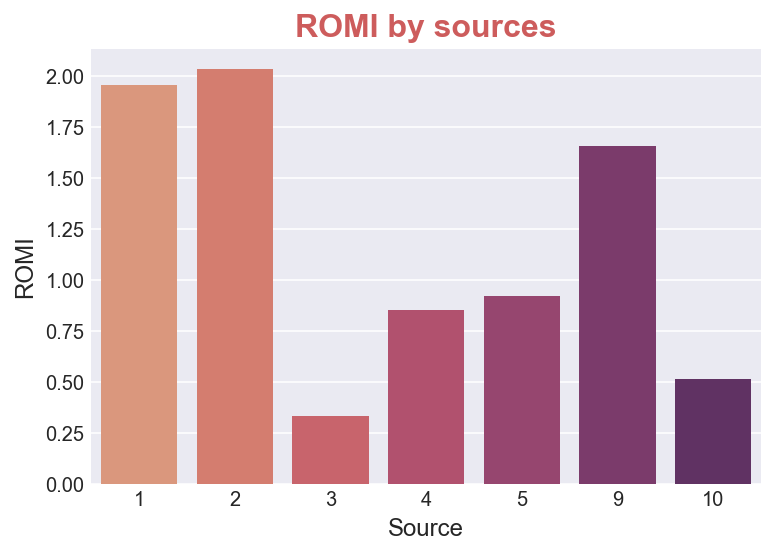

In [115]:
sns.barplot(
    x='source_id',
    y='romi',
    data=romi_by_sources,
    palette='flare'
)
plt.title('ROMI by sources', fontsize=16, fontweight='bold', color='indianred')
plt.xlabel('Source', fontsize=12)
plt.ylabel('ROMI', fontsize=12);

Подтвердились выводы из той части проекта, где мы рассмотрели долю пользователей, совершавших и не совершавших покупки, по источникам. Лучше всего окупаются (и в принципе окупаются: ROMI у них больше 1) 1, 2 и 9 источники.  
  
Хуже всего — третий, на который мы тратим больше всего денег. 4 и 5 источники немного не дотянули до окупаемости. Возможно, их можно оптимизировать или что-то сделать для того, чтобы они приносили чуть больше денег.

<a id="conclusion"></a>

## Итоговый вывод (и рекомендации)

1. Сайт более популярен в холодное время года. Но и на привлечение пользователей в холодное время тратилось в 2 раза больше денег. Возможно, дело только в этом, а возможно, в люди более активно ходят в театры и кино, потому что на улице холодно.
2. 31 марта 2018 года на сайт заходил всего 1 пользователь. Нужно понять, в чем была проблема: сломался счётчик или не работал сайт. Или что-то ещё.
3. Более 90% пользователей заходят на сайт только однажды, а затем уходят навсегда. Нужно подумать над тем, как убедить их вернуться. Например, усовершенствовать рассылки. А тех, кто не сделал заказ, убедить оставить почту, чтобы мы могли присылать им персонализированные предложения.
4. В среднем пользователи тратят 1 минуту с момента захода на сайт до заказа. Или у нас очень быстрый механизм оплаты, или что-то не так со счётчиком. Нужно это проверить.
5. Когорты июня и сентября 2017 года приносят больше всего денег. Стоит изучить, что им понравилось, чтобы улучшить опыт других пользователей. Эти когорты — самые перспективные для компании. Пока рано об этом говорить, но, возможно, прибыльными будут когорты декабря 2017 года и марта 2018-го.
6. Пользователи, приходящие из 1, 2 и 9 источников относительно чаще становятся покупателями и в итоге приносят прибыль. На эти источники тратится мало средств, но они очень хорошо окупаются. На них стоит тратить больше денег (если это возможно).
7. Пользователи из источников 3, 4 и 5 реже становятся покупателями. При этом источник 3 окупается хуже всех, в то время как на него тратится больше всего денег. Расходы нужно урезать, а также, если это контекстная реклама, попробовать её оптимизировать и увеличить конверсию. 
8. Источники 4 и 5 показывают себя не так плохо и лишь слегка не дотягивают до окупаемости. Стоит попробовать их оптимизировать и вывести в плюс, а если не получится — урезать расходы, ведь тратится на них существенная часть маркетингового бюджета.
9. Источники 6, 7 и 8 не приносят ни пользователей, ни заказов. При этом пользователей, пришедших из источника 8, вообще нет в таблице с посещениями сайта. На них и не тратятся деньги. Возможно, это переходы из соцсетей.

### Рекомендации по расходам (кратко)

1. Увеличить расходы на источники 1, 2 и 9.
2. Урезать расходы на источник 3.
3. Попытаться улучшить источники 4 и 5 и вывести их в плюс.